# Week 5: Project practice - Solutions

#### This file contains example solutions to the data-fitting problems of week 5. Given the nature of scientific projects, your results are likely to differ and your code may look different to mine - the purpose of the practical is to practice solving issues and analysing results independently. Where your results are most likely to differ from mine, I will point this out.

In this project, you will put into practice the skills you have learnt in the course. Our hope is that by seeing how all the methods you have used can be combined, then you will have more confidence in conducting your own projects next week.

<div>
<img src="attachment:overview_idea2_small.png" width="500"/>
</div>

If you have not yet watched Richard Feynman's video on modelling philosophy that was introduced in an earlier practical, you can watch it here: https://www.youtube.com/watch?app=desktop&v=EYPapE-3FRw

##### It is ok to take a guess!!

The project will be outlined as follows:

Part 1: based on schematics and written information, use dimension analysis to select the correct model

Part 2: analytically solve system for steady states, Jacobian, calculate eigenvalues and find limits on parameters

Part 3: write code to check that simulations provide same eigenvalue conclusions as analytical answer

Part 4: plot 3-dimensional phase portraits

Part 5: estimating eigenvalues from time-series data

Part 6: given a dataset (for $N_i = 80$ with varying $\delta$, see below), fit model to data

Part 7: validate model against data where $N_i = 514$

Part 8: make a hypothesis for new experimental conditions.

At various moments, we will practice how best to write figure captions and how to analyse results in your report.

In [ ]:
import numpy as np
from numpy.linalg import eigvals
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# new packages for data fitting
import scipy.stats.qmc as lhs # for Latin Hypercube sampling (parameter scanning)
from scipy.interpolate import interp1d # for simulation interpolation in your scoring function
import scipy.optimize as opt # for constrained minimisation

# new package to help find steady states of limit cycle oscillators
from scipy.signal import find_peaks

## Part 1: Model selection based on prior information and model dimensions

This project is based on a model from Fussman et al. (2000, doi: 10.1126/science.290.5495.1358) describing the concentration of Chlorella ($C$) and Brachionus ($B$) within a chemostat that has a continuous flow of nitrogen ($N$) into the system (see the figure below). Do not cheat and look at the paper yet! After completing your modelling, you can go read the paper and see what they did.

In this part of the project, you are provided with a picture of the system and the following prior knowledge. You could imagine this system to be a bioreactor containing the microbial populations, or a system found in a natural environment that is ignoring other external factors (temperature, light, etc...).

The nitrogen available to the microbes ($N_i$) enters the system with rate $\delta$, which is also the diluton rate of the microbes and internal nitrogen out of the system. Once in the system, the nitrogen is taken up by the Chlorella bacteria to provide energy for population growth (with maximum rate $b_c$). Note that the Chlorella cannot take up unlimited amounts of nitrogen and so their ability to consume nitrogen will saturate.

The Brachionus then consumes Chlorella (with maximum rate $b_b$) to stimulate it's own population growth. Again, the efficiency of Brachionus to grow in a Chlorella-dependent manner saturates and not all of the Chlorella consumed is used by the Brachionus for population growth (i.e. more Chlorella is consumed than Brachionus uses, and this is modelled with a dimensionless value $\epsilon$). Finally, the Brachionus dies with rate $m$ in combination with dilution out of the system (Chlorella does not die in this system, or does so much slower than the timescales we are interested in here).

All measurements are conducted over 80-90 days, and the concentration of each component in the bioreactor is measured. (Note that the paper uses a scaling factor to convert concentrations of microbial species and the number of cells in the bioreactor. We will ignore this for now and assume all data is just concentration.)

![system_figure.png](attachment:system_figure.png)

You are provided with three possible models that describe this system below. Your job is to use the information above, as well as checking the dimensions of the models, to select the correct model with consistent units and provide the biological interpretation of the parameters in this system.

Model A:

\begin{align}
\frac{dN}{dt} &= {\delta}\bigg(N_i - N\bigg) - b_cNC \nonumber \\
\frac{dC}{dt} &= \frac{b_cN}{K_c + N}C - b_bCB - \delta{C} \nonumber \\
\frac{dB}{dt} &= \epsilon\frac{b_bC}{K_b + C}B - (\delta + m)B \nonumber
\end{align}

Model B:

\begin{align}
\frac{dN}{dt} &= {\delta}\bigg(N_i - N\bigg) - \frac{b_cN}{K_c + N}C \nonumber \\
\frac{dC}{dt} &= \frac{b_cN}{K_c + N}C - \frac{b_bC}{K_b + C}\frac{B}{\epsilon} - \delta{C} \nonumber \\
\frac{dB}{dt} &= \frac{b_bC}{K_b + C}B - (\delta + m)B \nonumber
\end{align}

Model C:

\begin{align}
\frac{dN}{dt} &= {\delta}\bigg(N_i - N\bigg) - \frac{b_cN}{K_c + N}C \nonumber \\
\frac{dC}{dt} &= \frac{b_cN}{K_c + N}C - b_bC\frac{B}{\epsilon} - \delta{C} \nonumber \\
\frac{dB}{dt} &= b_bCB - (\delta + m)B \nonumber
\end{align}

## Solution

The correct model to select is Model B. The reason for this is two-fold:

1. Model A contains an inconsistent dimension check. Parameter $b_b$ has units of [concentration]$^{-1}$[time]$^{-1}$ in the equation for $\frac{dC}{dt}$ but units of [time]$^{-1}$ in $\frac{dB}{dt}$.

2. Model C contains an incorrect function required by the system description. Consumption of $C$ to produce $B$ "saturates". The mathematical expression used here ($b_cCB$) shows no saturation.

Model B contains the appropriate functions for saturation and all parameters are consistent such that $b_c$, $b_b$, $\delta$, and $m$ has units of [time]$^{-1}$, and $K_c$, $K_b$, and $\epsilon$ have units of [concentration] within the bioreactor.

## Part 2: Analytically find steady states, Jacobian, and limits on parameters

With the ODEs to hand of the correct model, you are now able to analyse this system.

a. First, prove that the following steady states are correct:

i. $(N_s, C_s, B_s) = (N_i, 0, 0)$

ii. $(N_s, C_s, B_s) = \bigg(\frac{\delta{K_c}}{b_c - \delta}, N_i - \frac{\delta{K_c}}{b_c-\delta}, 0\bigg)$.

Hint: you will find the $C_s = f(N_s)$ - some function that depends on $N_s$. This means you will need to substitute your solution for $N_s$ into $C_S$ to complete the proof.

iii. Other steady states exist when $C_s = \frac{(\delta + m)K_b}{b_b - (\delta + m)}$. You do not need to calculate the steady states of $B_s$ and $N_s$ in this case.

Hint: consider the case where $dB/dt = 0$.

b. Then, calculate the Jacobian matrix and evaluate the eigenvalues using the first, trivial steady state $(N_s,C_s,B_s) = (N_i,0,0)$. From the eigenvalues, show that the stability of the system at this steady state depends on whether $\delta$ is less than or greater than $\frac{b_c{N_i}}{K_c + N_i}$.

Hint: to make your calculations easier, substitute the steady state values into the Jacobian matrix once you have derived the partial derivatives.

## Solution

#### a. find steady states of the system.

i. Let's first take what happens when $C_s = B_s = 0$. From $\frac{dN}{dt} = 0$ we get

\begin{align}
\delta\bigg(N_i - N_{C=0}\bigg) &= 0 \nonumber \\
\Rightarrow N_{C=0} &= N_i \nonumber
\end{align}

confirming what we needed.

ii. Now let's see what happens when $B_s = 0$ but $C_s$ takes on some other value. In this case we find in $\frac{dN}{dt} = 0$ that

\begin{align}
\delta\bigg(N_i - N_s\bigg) - \frac{b_cN_s}{K_c + N_s}C_s &= 0 \nonumber \\
\Rightarrow C_s &= \delta\bigg(N_i - N_s\bigg)\frac{K_c + N_s}{b_cN_s} \nonumber
\end{align}

and in $\frac{dC}{dt} = 0$ that

\begin{align}
\frac{b_cN_s}{K_c + N_s} - \delta &= 0 \nonumber \\
\Rightarrow b_cN_s &= \delta\Bigg(K_c + N_s\Bigg) \nonumber \\
\Rightarrow N_s\Bigg(b_c-\delta\Bigg) &= \delta{K_c} \nonumber \\
\Rightarrow N_s &= \frac{\delta{K_c}}{b_c - \delta} \nonumber
\end{align}

which upon substitution gives us

\begin{align}
C_s &= \delta\bigg(N_i - N_s\bigg)\frac{K_c + N_s}{b_cN_s} \nonumber \\
\Rightarrow C_s &= \delta\bigg(N_i - \frac{\delta{K_c}}{b_c - \delta}\bigg)\frac{K_c + \frac{\delta{K_c}}{b_c - \delta}}{\frac{b_c\delta{K_c}}{b_c - \delta}} \nonumber \\
\Rightarrow C_s &= \bigg(N_i-\frac{\delta{K_c}}{b_c-\delta}\bigg)\frac{\bigg(K_c(b_c-\delta)+\delta{K_c}\bigg)}{b_cK_c} \nonumber \\
\Rightarrow C_s &= N_i - \frac{\delta{K_c}}{b_c-\delta} \nonumber
\end{align}

as desired. Note, that this problem could also be solved with substitution and checking the ODEs equal zero!

iii. Finally, we need to prove that $C_s = \frac{(\delta + m)K_b}{b_b - (\delta + m)}$ is a steady state. This can be found by setting $\frac{dB}{dt} = 0$ to get

\begin{align}
\frac{b_bC_s}{K_b + C_s}B_s - (\delta + m)B_s &= 0 \nonumber \\
\Bigg(\frac{b_bC_s}{K_b + C_s} - (\delta + m)\Bigg)B_s &= 0 \nonumber
\end{align}

so either $B_s = 0$ or $C_s = \frac{(\delta + m)K_b}{b_b - (\delta + m)}$ (and when this is the case $B_s$ and $N_s$ will be nonzero).

From all this we have our steady states $(N_{s}, C_{s}, B_{s}) = (N_i,0,0), \bigg(\frac{\delta{K_c}}{b_c - \delta}, N_i(b_c-\delta) - \delta{K_c}, 0\bigg)$ and a further steady state when $C = C_s$ above.

#### b. compute Jacobian and evaluate eigenvalues at trivial steady state.

We can now check stability of ODE system. Recall we need

\begin{equation}
J =
\begin{pmatrix}
\frac{\partial{f_1}}{\partial{N}} & \frac{\partial{f_1}}{\partial{C}} & \frac{\partial{f_1}}{\partial{B}} \\
\frac{\partial{f_2}}{\partial{N}} & \frac{\partial{f_2}}{\partial{C}} & \frac{\partial{f_2}}{\partial{B}} \\
\frac{\partial{f_3}}{\partial{N}} & \frac{\partial{f_3}}{\partial{C}} & \frac{\partial{f_3}}{\partial{B}}
\end{pmatrix} \nonumber
\end{equation}

and we can find

\begin{align}
\frac{\partial{f_1}}{\partial{N}} &= -\delta - \frac{b_cC}{K_C + N} + \frac{b_cCN}{(K_c + N)^2} \nonumber \\
\frac{\partial{f_1}}{\partial{C}} &= -\frac{b_cN}{K_C + N} \nonumber \\
\frac{\partial{f_1}}{\partial{B}} &= 0 \nonumber \\
\frac{\partial{f_2}}{\partial{N}} &= \frac{b_cC}{K_C + N} - \frac{b_cCN}{(K_c + N)^2} \nonumber \\
\frac{\partial{f_2}}{\partial{C}} &= \frac{b_cN}{K_C + N} - \frac{b_b}{K_b + C}\frac{B}{\epsilon} + \frac{b_bC}{(K_b + C)^2}\frac{B}{\epsilon} - \delta \nonumber \\
\frac{\partial{f_2}}{\partial{B}} &= -\frac{b_bC}{K_b + C}\frac{1}{\epsilon} \nonumber \\
\frac{\partial{f_3}}{\partial{N}} &= 0 \nonumber \\
\frac{\partial{f_3}}{\partial{C}} &= \frac{b_bB}{K_b + C} - \frac{b_bCB}{(K_b + C)^2} \nonumber \\
\frac{\partial{f_3}}{\partial{B}} &= \frac{b_bC}{K_b + C} - \delta - m \nonumber
\end{align}

This leads to the general characteristic equation

\begin{align}
\|J - \lambda{I}\| &= \Bigg(\frac{\partial{f_1}}{\partial{N}} - \lambda\Bigg)\Bigg[\Bigg(\frac{\partial{f_2}}{\partial{C}} - \lambda\Bigg)\Bigg(\frac{\partial{f_3}}{\partial{B}}-\lambda\Bigg) - \frac{\partial{f_2}}{\partial{B}}\frac{\partial{f_3}}{\partial{C}}\Bigg] - \frac{\partial{f_1}}{\partial{C}}\Bigg[\frac{\partial{f_2}}{\partial{N}}\Bigg(\frac{\partial{f_3}}{\partial{B}} - \lambda\Bigg)\Bigg] = 0 \nonumber \\
\Rightarrow 0 &= \Bigg(\frac{\partial{f_1}}{\partial{N}}-\lambda\Bigg)\Bigg(\frac{\partial{f_2}}{\partial{C}}-\lambda\Bigg)\Bigg(\frac{\partial{f_3}}{\partial{B}} - \lambda\Bigg) - \Bigg(\frac{\partial{f_1}}{\partial{N}} - \lambda\Bigg)\frac{\partial{f_2}}{\partial{B}}\frac{\partial{f_3}}{\partial{C}} - \frac{\partial{f_1}}{\partial{C}}\frac{\partial{f_2}}{\partial{N}}\Bigg(\frac{\partial{f_3}}{\partial{B}} - \lambda\Bigg) \nonumber \\
\Rightarrow 0 &= -\lambda^3 + \lambda^2\Bigg(\frac{\partial{f_1}}{\partial{N}} + \frac{\partial{f_2}}{\partial{C}} + \frac{\partial{f_3}}{\partial{B}}\Bigg) - \lambda\Bigg(\frac{\partial{f_1}}{\partial{N}}\frac{\partial{f_2}}{\partial{C}} + \frac{\partial{f_1}}{\partial{N}}\frac{\partial{f_3}}{\partial{B}} + \frac{\partial{f_2}}{\partial{C}}\frac{\partial{f_3}}{\partial{B}} - \frac{\partial{f_2}}{\partial{B}}\frac{\partial{f_3}}{\partial{C}} - \frac{\partial{f_1}}{\partial{C}}\frac{\partial{f_2}}{\partial{N}}\Bigg) + \frac{\partial{f_1}}{\partial{N}}\frac{\partial{f_2}}{\partial{C}}\frac{\partial{f_3}}{\partial{B}} - \frac{\partial{f_1}}{\partial{N}}\frac{\partial{f_2}}{\partial{B}}\frac{\partial{f_3}}{\partial{C}} - \frac{\partial{f_1}}{\partial{C}}\frac{\partial{f_2}}{\partial{N}}\frac{\partial{f_3}}{\partial{B}} \nonumber
\end{align}

We can solve this in the trivial case the $(N_s,C_s,B_s) = (N_i,0,0)$ to find that

\begin{align}
\Bigg(-\delta - \lambda_1\Bigg)\Bigg(\frac{b_c{N_i}}{K_c + N_i} - \delta - \lambda_2\Bigg)\Bigg(-\delta - m - \lambda_3\Bigg) &= 0 \nonumber \\
\Rightarrow \lambda_1 &= -\delta \nonumber \\
\lambda_2 &= \frac{b_c{N_i}}{K_c + N_i} - \delta \nonumber \\
\lambda_3 &= -\delta - m \nonumber
\end{align}

Now, if $\delta \leq \frac{b_cN_i}{K_c+N_i}$, then the second eigenvalue, $\lambda_2$, will be positive or zero. Therefore, we have two negative eigenvalues and one positive eigenvalue. This suggests that the system is unstable at this steady state and that a perturbation (e.g. by perturbing the $B$ and $C$ concentration) will push the system away from the steady state. However, if $\delta \geq \frac{b_cN_i}{K_c+N_i}$ then all eigenvalues are negative and the steady state is stable.

We expect this steady state to be stable so we have a lower limit for $\delta$!

## Part 3: code eigenvalue analysis for the trivial steady state

Following the mathematical exercise above, use the functions you were introduced to in previous weeks to check whether the eigenvalues calculated above are correct or not. If the eigenvalue analysis that you have coded provides the same eigenvalues as you calculated above, then you know that there are no errors anywhere (or at least it is less likely that errors exist!)

At this moment, you won't know any reaction rates or experimental conditions, so we just want to check that the code provides the same solution as what you obtained above. You can do this by setting $N_i = 80, \delta = 1.24$ and the rest of the parameters as random values. For my solutions I have used:

\begin{align}
b_b &= 6.0729613047868 \nonumber \\
K_b &= 7.689252558450469 \nonumber \\
K_c &= 7.750164089986351 \nonumber \\
\epsilon &= 0.8540979916877038 \nonumber \\
m &= 0.14908503523255445 \nonumber
\end{align}

Write code for the entries of the Jacobian matrix given any steady state, and then use eigenvalue functions to calculate the eigenvalues when $\bigg(N_s, C_s, B_s\bigg) = \bigg(N_i, 0, 0\bigg)$.

Test this for two values of $b_c$:

i. 7.5296553231688605

ii. 0.75296553231688605

You should find that one value produces an unstable steady state, and another a stable steady state. Check the values produced by your code with those above that you derived.

Recall that the functions you used to calculate eigenvalues were:

Python = eigvals from the numpy linalg package

R = eigen function

#### Debug note

You may ask yourself "Do we need so many decimal places for our parameter values?"

Unfortunately, for this model the answer appears to be yes. When you come to code your ODEs in the next part of the project, you can try to simulate the model with these parameters and with rounded values - with rounded values I found the ODE solver could not produce a solution! We will elaborate on this issue later...

## Solution

In [ ]:
# set parameter values
Ni = 80
d = 1.24
bb = 6.0729613047868
bc = 7.5296553231688605
Kb = 7.689252558450469
Kc = 7.750164089986351
eps = 0.8540979916877038
m = 0.14908503523255445

print("Value of delta bound is...")
print(bc*Ni/(Kc+Ni))

# set steady state values
n_Ss = Ni
c_Ss = 0
b_Ss = 0

# calculate partial derivates for Jacobian
f1n = -d - bc*c_Ss/(Kc+n_Ss) + bc*c_Ss*n_Ss/((Kc+n_Ss)**2)
f1c = -bc*n_Ss/(Kc+n_Ss)
f2n = bc*c_Ss/(Kc+n_Ss) - bc*c_Ss*n_Ss/((Kc+n_Ss)**2)
f2c = bc*n_Ss/(Kc+n_Ss) - bb*(b_Ss/eps)/(Kb+c_Ss) + bb*c_Ss*(b_Ss/eps)/((Kb+c_Ss)**2) - d
f2b = -bb*(c_Ss/eps)/(Kb+c_Ss)
f3c = bb*b_Ss/(Kb+c_Ss) - bb*c_Ss*b_Ss/((Kb+c_Ss)**2)
f3b = bb*c_Ss/(Kb+c_Ss) - d - m

# calculate eigenvalues
J = np.array([[f1n, f1c, 0],[f2n, f2c, f2b],[0, f3c, f3b]])
eigs = eigvals(J)

print("Jacobian matrix is...")
print(J)
print("Calculated eigenvalues are...")
print(eigs)
print("Derived eigenvalues are...")
print(np.array([-d,bc*Ni/(Kc+Ni)-d,-d-m]))

Value of delta bound is...
6.864630193007796
Jacobian matrix is...
[[-1.24       -6.86463019  0.        ]
 [ 0.          5.62463019 -0.        ]
 [ 0.          0.         -1.38908504]]
Calculated eigenvalues are...
[-1.24        5.62463019 -1.38908504]
Derived eigenvalues are...
[-1.24        5.62463019 -1.38908504]


In [ ]:
# change bc value
bc = 0.75296553231688605

print("Value of delta bound is...")
print(bc*Ni/(Kc+Ni))

# calculate partial derivates for Jacobian
f1n = -d - bc*c_Ss/(Kc+n_Ss) + bc*c_Ss*n_Ss/((Kc+n_Ss)**2)
f1c = -bc*n_Ss/(Kc+n_Ss)
f2n = bc*c_Ss/(Kc+n_Ss) - bc*c_Ss*n_Ss/((Kc+n_Ss)**2)
f2c = bc*n_Ss/(Kc+n_Ss) - bb*(b_Ss/eps)/(Kb+c_Ss) + bb*c_Ss*(b_Ss/eps)/((Kb+c_Ss)**2) - d
f2b = -bb*(c_Ss/eps)/(Kb+c_Ss)
f3c = bb*b_Ss/(Kb+c_Ss) - bb*c_Ss*b_Ss/((Kb+c_Ss)**2)
f3b = bb*c_Ss/(Kb+c_Ss) - d - m

# calculate eigenvalues
J = np.array([[f1n, f1c, 0],[f2n, f2c, f2b],[0, f3c, f3b]])
eigs = eigvals(J)

print("Jacobian matrix is...")
print(J)
print("Calculated eigenvalues are...")
print(eigs)
print("Derived eigenvalues are...")
print(np.array([-d,bc*Ni/(Kc+Ni)-d,-d-m]))

Value of delta bound is...
0.6864630193007797
Jacobian matrix is...
[[-1.24       -0.68646302  0.        ]
 [ 0.         -0.55353698 -0.        ]
 [ 0.          0.         -1.38908504]]
Calculated eigenvalues are...
[-1.24       -0.55353698 -1.38908504]
Derived eigenvalues are...
[-1.24       -0.55353698 -1.38908504]


## Part 4: plotting 3-dimensional phase portraits to estimate steady states

You have already calculated two sets of steady states - $\bigg(N_i, 0, 0\bigg)$ and $\bigg(\frac{\delta{K_c}}{b_c - \delta}, N_i - \frac{\delta{K_c}}{b_c-\delta}, 0\bigg)$ - but there is a third set that is dependent on the reaction rates

\begin{align}
N_s &= \frac{1}{2\delta}\bigg[\delta(N_i-K_c)-b_cC_s + \sqrt{(\delta(N_i-K_c)-b_cC_s)^2 + 4\delta^2N_iK_c}\bigg] \nonumber \\
C_s &= \frac{K_b(\delta+m)}{b_b - \delta - m} \nonumber \\
B_s &= \frac{\epsilon}{b_b}(K_b+C_s)\Bigg(\frac{b_cN_s}{K_c+N_s} - \delta\Bigg) \nonumber
\end{align}

This shows that the steady states depend on the reaction rates of the system: as you have seen earlier in the course with phase portraits. In this instance, changing $b_c$ alters the stability of the system and gives rise to a Hopf bifurcation.

We can also use time-series and phase portraits to estimate what the steady state of a limit cycle should be without knowledge of the reaction rates - which may be useful later in this exercise and in your project when you do not know what the analytical steady state equations or reaction rates are!

Here, we will go through the steps needed for this analysis, compare the output of our estimated time-series with the equations given above, and then create a function for steady state estimation that you can use later regardless of whether the system oscillates or not.

We will simulate the system from $t = 0$ to $t = 80$ days from initial conditions $(N, C, B) = (65,3,8)$.

I will go through the steps for $b_c = 7.5296553231688605$ and then I would like you to confirm that the estimated steady states match the equations above for $b_c = 0.75296553231688605$.

Let's start by coding and simulating the system for $b_c = 7.5296553231688605$. To confirm the simulation works, I will plot the time-series.

#### Debug Note

In principle, you can follow these steps for any parameter set. However, depending on the reaction rates, I did sometimes get errors when simulating the ODE model as the ODE solver sometimes "breaks" at timepoints earlier than $t = 80$, so I advise that you use the provided example parameter set above. This is related to why we have so many decimal places for the parameters provided earlier in the notebook.

Without going into too many details, this is due to how ODE solvers work... sometimes, with so-called "stiff" models, ODE solvers struggle to calculate the next simulated time-point within the allowed error tolerances - and remember that ODE solvers are trying to estimate the solution to equations within a certain error. When this happens, the ODE solver will start to predict negative concentrations and values will "explode" to very large positive or negative values very quickly.

Solutions to this problem include: (i) changing the tolerances of the ODE solver you are using, (ii) use a different solver entirely (e.g. more advanced methods such as LSODA), (iii) re-coding the model to prevent negative solutions by "force", or (iv) formulating the model in a less "stiff" way. All of these topics are too advanced for this course but are useful to be aware of.

In [ ]:
# code ODE model that takes state, time, and parameters as an input, and outputs dx/dt

def ncb_model(x, t, Ni, d, bb, bc, Kb, Kc, eps, m):

    n = x[0]
    c = x[1]
    b = x[2]

    dndt = d*(Ni - n) - (bc*n/(Kc+n))*c
    dcdt = (bc*n/(Kc+n))*c - (bb*c/(Kb+c))*b/eps - d*c
    dbdt = (bb*c/(Kb+c))*b - (d+m)*b

    dxdt = [dndt,dcdt,dbdt]

    return dxdt

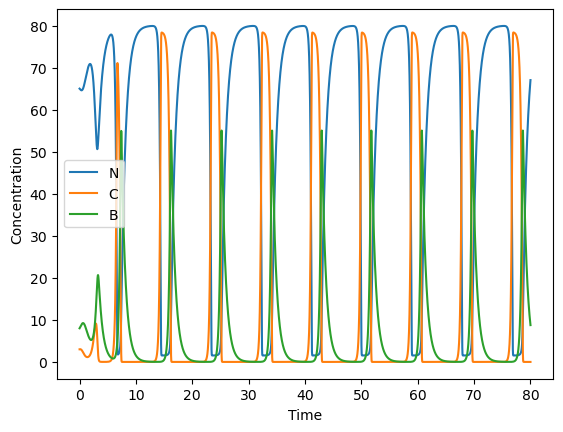

In [ ]:
# Set parameter values
Ni = 80
d = 1.24
bb = 6.0729613047868
bc = 7.5296553231688605
Kb = 7.689252558450469
Kc = 7.750164089986351
eps = 0.8540979916877038
m = 0.14908503523255445

# Set timespan and initial conditions
times = np.linspace(0,80,8001)
initial_conditions = [65,3,8]

# Simulate model
pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
xt = odeint(ncb_model, initial_conditions, times, pars)

# Check timeseries by plotting concentrations against time
plt.plot(times,xt[:,0],label="N")
plt.plot(times,xt[:,1],label="C")
plt.plot(times,xt[:,2],label="B")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

We can also calculate what we expect the steady states to be based on the reaction rates:

In [ ]:
# steady state 1
print("Steady state 1 is...")
ss1 = [Ni,0,0]
print(ss1)

# steady state 2
print("Steady state 2 is...")
ss2 = [d*Kc/(bc-d),Ni-d*Kc/(bc-d),0]
print(ss2)

# steady state 3
print("Steady state 3 is...")
Cs = Kb*(d+m)/(bb-d-m)
Ns = (1/(2*d))*(d*(Ni-Kc)-bc*Cs+np.sqrt((d*(Ni-Kc)-bc*Cs)**2+4*Ni*Kc*d**2))
Bs = (eps/bb)*(Kb+Cs)*((bc*Ns/(Kc+Ns))-d)
ss3 = [Ns,Cs,Bs]
print(ss3)

Steady state 1 is...
[80, 0, 0]
Steady state 2 is...
[1.5279380153285178, 78.47206198467148, 0]
Steady state 3 is...
[67.57751203727611, 2.2803816852496976, 7.732656356789158]


We see here that, for these parameter sets, all three steady states are biologically plausible, but which one is correct?

Now we can plot the three species on a 3-dimensional phase portrait. To make it easier to see the direction of travel, I will highlight the starting point with a yellow dot, and the final dot with a red dot. To do this, you can use the code:

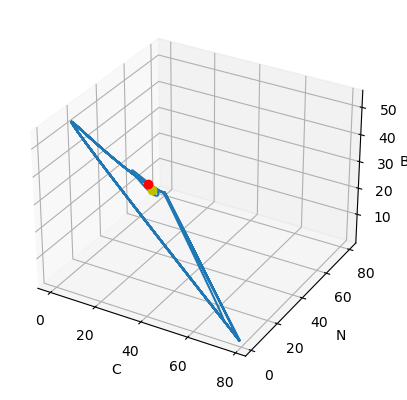

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xt[:,1],xt[:,0],xt[:,2])
ax.plot(xt[0,1],xt[0,0],xt[0,2],"yo")
ax.plot(xt[-1,1],xt[-1,0],xt[-1,2],"ro")
ax.set_xlabel("C")
ax.set_ylabel("N")
ax.set_zlabel("B")
ax.zaxis.labelpad=-0.7
plt.show()

We see here that we have an oscillating system, so how do we estimate the steady state of this system?

This is where the Scipy package find_peaks and the function geometric_median (given below) become very useful.

Given a time-series, the find_peaks functions finds the concentrations of species when each of our components has a peak in the oscillation, i.e. we can estimate coordinates of the three limit cycle extreme points seen in the phase portrait!

Given these coordinates, we can then estimate the center/geometric median of the limit cycle, which is the steady state around which the system oscillates.

This is not a perfect estimation (as our limit cycles may not be symmetric) but, for the purpose of deriving eigenvalues later, this should suffice!

Because I do not want to use the entire simulated time-series, but only the simulation when the system is on a limit cycle oscillator, then I will find_peaks in the last 25% of the time-series.

This can be done with the following code:

In [ ]:
import math
def geometric_median(X, numIter = 1000):
    """
    Compute the geometric median of a point sample.
    The geometric median coordinates will be expressed in the Spatial Image reference system (not in real world metrics).
    We use the Weiszfeld's algorithm (http://en.wikipedia.org/wiki/Geometric_median)

    :Parameters:
     - `X` (list|np.array) - voxels coordinate (3xN matrix)
     - `numIter` (int) - limit the length of the search for global optimum

    :Return:
     - np.array((x,y,z)): geometric median of the coordinates;
    """
    # -- Initialising 'median' to the centroid
    y = np.mean(X,1)
    # -- If the init point is in the set of points, we shift it:
    while (y[0] in X[0]) and (y[1] in X[1]) and (y[2] in X[2]):
        y+=0.1

    convergence=False # boolean testing the convergence toward a global optimum
    dist=[] # list recording the distance evolution

    # -- Minimizing the sum of the squares of the distances between each points in 'X' and the median.
    i=0
    while ( (not convergence) and (i < numIter) ):
        num_x, num_y, num_z = 0.0, 0.0, 0.0
        denum = 0.0
        m = X.shape[1]
        d = 0
        for j in range(0,m):
            div = math.sqrt( (X[0,j]-y[0])**2 + (X[1,j]-y[1])**2 + (X[2,j]-y[2])**2 )
            num_x += X[0,j] / div
            num_y += X[1,j] / div
            num_z += X[2,j] / div
            denum += 1./div
            d += div**2 # distance (to the median) to miminize
        dist.append(d) # update of the distance evolution

        if denum == 0.:
            warnings.warn( "Couldn't compute a geometric median, please check your data!" )
            return [0,0,0]

        y = [num_x/denum, num_y/denum, num_z/denum] # update to the new value of the median
        if i > 3:
            convergence=(abs(dist[i]-dist[i-2])<0.1) # we test the convergence over three steps for stability
            #~ print abs(dist[i]-dist[i-2]), convergence
        i += 1
    if i == numIter:
        raise ValueError( "The Weiszfeld's algoritm did not converged after"+str(numIter)+"iterations !!!!!!!!!" )
    # -- When convergence or iterations limit is reached we assume that we found the median.

    return np.array(y)

In [ ]:
# calculate 25% of timeseries as we assume oscillations will be observed in this timeframe
t25 = int(np.ceil(len(xt[:,0])/4))
n_t = xt[-t25:,0]
c_t = xt[-t25:,1]
b_t = xt[-t25:,2]

# calculate from time-series sets of concentrations when N, C, and B peak in turn
peaksN, _ = find_peaks(n_t, height=10)
peaksC, _ = find_peaks(c_t, height=10)
peaksB, _ = find_peaks(b_t, height=10)
print(xt[-t25+peaksN,:])
print(xt[-t25+peaksC,:])
print(xt[-t25+peaksB,:])

# we then end up with a collection of coordinates where peaks exist in the phase portrait
# we want the last set of extremities: do these match the image above??
xt_array = np.concatenate([xt[-t25+peaksN,:],xt[-t25+peaksC,:],xt[-t25+peaksB,:]])
print(xt_array)

# let's estimate the central point of the limit cycle: does this match the analytical expressions above??
xt_Ss = geometric_median(xt_array)
print(xt_Ss)

[[7.99170845e+01 1.49847282e-02 2.44178350e-02]
 [7.99170994e+01 1.47210474e-02 2.45175365e-02]]
[[ 1.53736014 78.36068619  0.08027548]
 [ 1.53865104 78.36066235  0.079206  ]]
[[10.79392944  2.49327745 55.02680989]
 [11.32712747  1.92995022 55.0120101 ]
 [11.08039843  2.17536434 55.03173469]]
[[7.99170845e+01 1.49847282e-02 2.44178350e-02]
 [7.99170994e+01 1.47210474e-02 2.45175365e-02]
 [1.53736014e+00 7.83606862e+01 8.02754838e-02]
 [1.53865104e+00 7.83606624e+01 7.92059998e-02]
 [1.07939294e+01 2.49327745e+00 5.50268099e+01]
 [1.13271275e+01 1.92995022e+00 5.50120101e+01]
 [1.10803984e+01 2.17536434e+00 5.50317347e+01]]
[13.33683751 13.33682636 21.15841688]


What we observe here is that the estimated center of the limit cycle does not match the analytical steady states but (we will see later) that the eigenvalues of the system give the correct conclusion. However, this is as an estimate. As we will see in the next part, the calculated eigenvalues will conclude that the system, evaluated at these points, is a limit cycle. Given the consistency of the conclusions, this approach can be considered ok but imperfect.

Now, repeat the following for $b_c = 0.75296553231688605$. Simulate the time-series and plot a 3-dimensional phase portrait. You should see that the system goes directly to a steady state.

In this instance, the find_peaks function will not work, so you can estimate the steady state directly by taking the final time-point or average concentration over the last 25% of the time-series. Compare this value with the derived steady state values above.

### Solution

First, let's simulate the system and plot time-series & phase portraits.

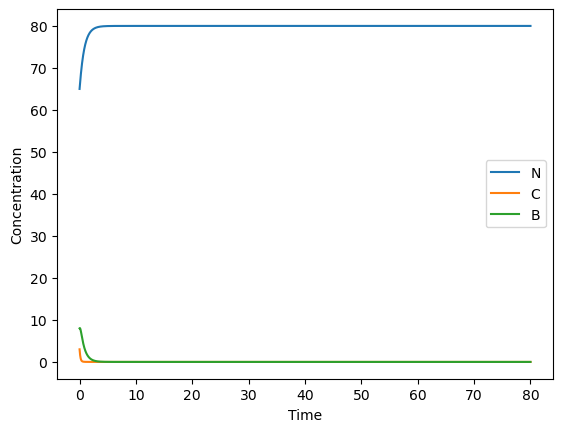

In [ ]:
# Set parameter values
Ni = 80
d = 1.24
bb = 6.0729613047868
bc = 0.75296553231688605
Kb = 7.689252558450469
Kc = 7.750164089986351
eps = 0.8540979916877038
m = 0.14908503523255445

# Set timespan and initial conditions
times = np.linspace(0,80,8001)
initial_conditions = [65,3,8]

# Simulate model
pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
xt = odeint(ncb_model, initial_conditions, times, pars)

# Check timeseries by plotting concentrations against time
plt.plot(times,xt[:,0],label="N")
plt.plot(times,xt[:,1],label="C")
plt.plot(times,xt[:,2],label="B")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

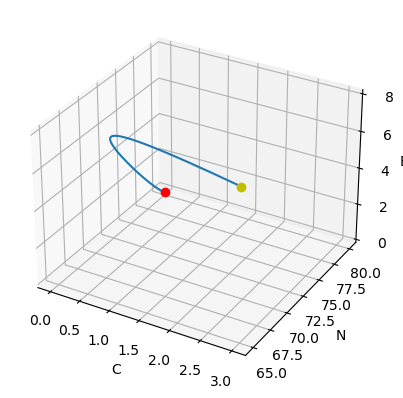

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xt[:,1],xt[:,0],xt[:,2])
ax.plot(xt[0,1],xt[0,0],xt[0,2],"yo")
ax.plot(xt[-1,1],xt[-1,0],xt[-1,2],"ro")
ax.set_xlabel("C")
ax.set_ylabel("N")
ax.set_zlabel("B")
ax.zaxis.labelpad=-0.7
plt.show()

Now let's calculate steady states from simulations...

In [ ]:
# calculate 25% of timeseries as we assume oscillations will be observed in this timeframe
t25 = int(np.ceil(len(xt[:,0])/4))
# for systems that decay to a steady state then we can take the timeseries directly
xt_array = xt[-t25:,:]

print("Simulated steady state is...")
xt_Ss = np.median(xt_array,axis=0)
print(xt_Ss)

Simulated steady state is...
[ 8.00000000e+01 -3.02367645e-11  5.27038325e-13]


In [ ]:
# steady state 1
print("Steady state 1 is...")
ss1 = [Ni,0,0]
print(ss1)

# steady state 2
print("Steady state 2 is...")
ss2 = [d*Kc/(bc-d),Ni-d*Kc/(bc-d),0]
print(ss2)

# steady state 3
print("Steady state 3 is...")
Cs = Kb*(d+m)/(bb-d-m)
Ns = (1/(2*d))*(d*(Ni-Kc)-bc*Cs+np.sqrt((d*(Ni-Kc)-bc*Cs)**2+4*Ni*Kc*d**2))
Bs = (eps/bb)*(Kb+Cs)*((bc*Ns/(Kc+Ns))-d)
ss3 = [Ns,Cs,Bs]
print(ss3)

Steady state 1 is...
[80, 0, 0]
Steady state 2 is...
[-19.73208080590283, 99.73208080590283, 0]
Steady state 3 is...
[78.7393650853793, 2.2803816852496976, -0.7774865627007926]


Only one of these steady states is biologically plausible and this is steady state 1. This also matches what we observe in and calculate from the time-series plots.

## Writing exercise: figure captions and how to write up results

In your project reports that you are due to write in the coming weeks, you are going to collect a lot of simulations and results. However, unless you have been trained how to correctly document results in the thesis research or other courses, you may be unaware of proper writing styles to describe/discuss results.

As we have now created some plots in Part 4, I would like us to take a moment to consider how we should write up our results in a professional/academic manner. We will compare your drafts with what ChatGPT gives you to highlight that completely trusting generative AI for this task may not be the best thing to do...

Let me start with an example. For this purpose I will take the oscillating time-series and phase portrait from above. To obtain the text below, I have taken a screen shot of both figures and copied these into ChatGPT with the following prompt: "For this figure, please provide a figure caption and a paragraph describing the results for a scientific report"

This is what I obtained for the time-series figure...

Figure caption:
Figure 1. Temporal oscillations of the concentrations of species N, C, and B. The plot shows the time evolution of the three interacting components, where N (blue), C (orange), and B (green) exhibit periodic behavior over a duration of 80 time units.

Results description:
The time-course data demonstrate that the concentrations of species N, C, and B undergo sustained oscillations, suggesting a stable limit-cycle dynamic within the system. Each species exhibits a repeating pattern characterized by distinct peaks and troughs that occur sequentially, indicating a phase-shifted relationship among the three variables. N reaches its maximum concentration first, followed by C and then B, before returning to baseline levels. This cyclical pattern persists throughout the observed time frame without damping, implying a robust oscillatory mechanism, potentially arising from nonlinear feedback interactions or coupled reaction kinetics. The regularity and persistence of these oscillations highlight the system’s intrinsic rhythmic stability.

For the phase portrait...

Figure caption:
Figure 2. Three-dimensional phase-space trajectory of the system showing the relationship between the concentrations of N, C, and B. The blue line represents the system’s trajectory in phase space, while the red marker indicates the initial condition and the yellow marker denotes the final state after simulation.

Results description:
The three-dimensional phase-space plot illustrates the dynamic relationship between the concentrations of N, C, and B over time. The system exhibits a closed-loop trajectory, characteristic of a stable limit cycle, confirming the presence of sustained oscillations observed in the time-series data. The cyclic path demonstrates that the system repeatedly passes through the same set of concentration states, indicating that the oscillations are neither damped nor divergent. The proximity of the initial (red) and final (yellow) points suggests that the oscillatory behavior is maintained over the simulation period without loss of amplitude, consistent with a self-sustaining oscillatory regime governed by nonlinear feedback mechanisms among the three components.

The general structure, here, is actually better than I expected... Notice in the figure caption that all line colours and dots present in each figure are described and the figures are not analysed (as this is left to the results description). If you desire - and this is sometimes important depending on the test you are doing - you should also include information about model parameters and initial conditions. This is particularly important if, in your tests, you are varying these values. So you could add:

"Model simulations were performed from initial conditions $(N(0), C(0), B(0)) = (65, 3, 8)$ with parameter values given as in the Methods section with $b_c = 7.5296553231688605$."

Now let's ask ourselves a few questions:

1. Is the information accurate in the caption and description?

No! Figure caption 2 tells us that the initial condition is marked with the red dot, and the final condition with the yellow dot but this is not correct!

2. Are the figures properly analysed in the description?

No! The results description do not relate the result to the model or context of the problem and do not go beyond what can be observed in the figure. To write your results with a good style, you should (i) refer to why you conducted the test, (ii) how you performed the test, (iii) what the test showed you and (iv) what you conclude from this. This means that, in your report, this paragraph links one test to the next test in a flowing story. I would aim for something along the lines of...

Timeseries figure: Our analysis of the bioreactor system suggested that, for $b_c = 7.5296553231688605$, limit cycle oscillations between nitrogen concentrations and our microbe populations. To test this, we simulated the system for 80 days. Our simulations showed that, after a short transient period, the system relaxes to an apparently stable oscillation. In this instance, nitrogen levels $N$ decrease as microbe populations $C$ and $B$ increase, and nitrogen building up in the reactor microbial populations are washed away.

Phase portrait figure: Our time-series showed that the bioreactor produces oscillations. To confirm that the system has relaxed to a stable limit cycle, we produced a phase portrait showing the oscillatory dynamics. Starting from the initial conditions (yellow point) the system trajectory relaxes to a stable limit cycle oscillation around an unstable steady state point. This is observed from the overlapping system orbits with each oscillation. This suggests that the balance of nitrogen and microbes in the reactor prevents the system from reaching stable steady states or reactor modes.

Now, practice this with the figures you produced for $b_c = 0.75296553231688605$. Write a figure caption and a results paragraph for the time-series and phase portrait plots. Have your neighbour check the text to make sure that it is accurate and follows the practices discussed above.

### Solution: practice your writing!

## Part 5: estimating eigenvalues from time-series

The steps we have taken above - to simulate the system and estimate steady states from time-series and phase portraits - can now be packaged into a function that we can re-use for any time-series. We will call this calculate_steadyStates. The input of this function is the simulated time-series, and the output is the estimated steady-state.

To simulate time-series for this problem, use the same time-frame, reaction rates, and initial conditions as in Part 4.

Now, we know for $b_c = 7.5296553231688605$ we have oscillations and for $b_c = 0.75296553231688605$ we have a system that decays to steady state equilibria. This means that our eigenvalues should be unstable (and ideally complex) when $b_c = 7.5296553231688605$ and negative when $b_c = 0.75296553231688605$.

The function calculate_eigenvalues takes the steady state concentrations as input and outputs the eigenvalues. Adapt this code, using the Jacobian matrix above, to finish the function. Note here that f1n is equivalent to $df_1/dN$ etc.

Compare the eigenvalues calculated from estimated steady states with the steady states derived analytically above.

Note: for your projects, you may wish to adapt these scripts to new problems!

In [ ]:
# These functions calculate steady states and eigenvalues of our 3-component ODE given a simulated set of concentrations.
# The code approximates steady states using the final 25% of the timeseries, or approximating the central point of a
# limit cycle phase portrait. These steady state values are then used in the Jacobian matrix entries that you have calculated
# above.

def calculate_steadyStates(x):

    # calculate 25% of timeseries as we assume oscillations will be observed in this timeframe
    t25 = int(np.ceil(len(x[:,0])/4))
    n_t = x[-t25:,0]
    c_t = x[-t25:,1]
    b_t = x[-t25:,2]

    # calculate steady states from the time-series
    try:
        # this loop will be attempted for limit cycle oscillators where we see "peaks" in 3D phase portraits and time-series
        # the find_peaks package is available from Scipy
        peaksN, _ = find_peaks(n_t, height=10)
        peaksC, _ = find_peaks(c_t, height=10)
        peaksB, _ = find_peaks(b_t, height=10)

        # we then end up with a collection of coordinates where peaks exist in the phase portrait
        # we want the last set of extremities: do these match the image above??
        xt_array = np.concatenate([xt[-t25+peaksN,:],xt[-t25+peaksC,:],xt[-t25+peaksB,:]])

        # let's estimate the central point of the limit cycle: does this match the analytical expressions above??
        xt_Ss = geometric_median(xt_array)
    except:
        # for systems that decay to a steady state then we can take the timeseries directly
        xt_array = xt[-t25:,:]

        # we can now calculate the mean values of these coordinates which should equate to the steady state for these
        # systems and a point close to the center of a 3D phase portrait for limit cycle oscillators
        xt_Ss = np.median(xt_array,axis=0)

    return xt_Ss

## Solution

In [ ]:
# You need to complete this code by correctly entering the Jacobian matrix.
# These Jacobian elements are code that you need to complete as you did above.
# f1n here implies df1/dN, for example.

def calculate_eigenvalues(x,Ni, d, bb, bc, Kb, Kc, eps, m):

    n_Ss = x[0]
    c_Ss = x[1]
    b_Ss = x[2]

    # calculate partial derivates for Jacobian
    f1n = -d - bc*c_Ss/(Kc+n_Ss) + bc*c_Ss*n_Ss/((Kc+n_Ss)**2)
    f1c = -bc*n_Ss/(Kc+n_Ss)
    f2n = bc*c_Ss/(Kc+n_Ss) - bc*c_Ss*n_Ss/((Kc+n_Ss)**2)
    f2c = bc*n_Ss/(Kc+n_Ss) - bb*(b_Ss/eps)/(Kb+c_Ss) + bb*c_Ss*(b_Ss/eps)/((Kb+c_Ss)**2) - d
    f2b = -bb*(c_Ss/eps)/(Kb+c_Ss)
    f3c = bb*b_Ss/(Kb+c_Ss) - bb*c_Ss*b_Ss/((Kb+c_Ss)**2)
    f3b = bb*c_Ss/(Kb+c_Ss) - d - m

    # calculate eigenvalues
    J = np.array([[f1n, f1c, 0],[f2n, f2c, f2b],[0, f3c, f3b]])
    eigs = eigvals(J)

    # output steady states and eigenvalues
    return eigs

In [ ]:
# Test code using a parameter set # Set parameter values
Ni = 80
d = 1.24
bb = 6.0729613047868
bc = 7.5296553231688605
Kb = 7.689252558450469
Kc = 7.750164089986351
eps = 0.8540979916877038
m = 0.14908503523255445

# Set timespan and initial conditions
times = np.linspace(0,80,8001)
initial_conditions = [65,3,8]

# Simulate model
pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
xt = odeint(ncb_model, initial_conditions, times, pars)

# Calculate steady states
x_Ss = calculate_steadyStates(xt)

# Calculate eigenvalues and print them
eigs = calculate_eigenvalues(x_Ss, Ni, d, bb, bc, Kb, Kc, eps, m)
print("Estimated eigenvalues are...")
print(eigs)

true_Ss = [67.57751203727611, 2.2803816852496976, 7.732656356789158]
true_eigs = calculate_eigenvalues(true_Ss, Ni, d, bb, bc, Kb, Kc, eps, m)
print("True eigenvalues are...")
print(true_eigs)

Estimated eigenvalues are...
[-1.28189726+0.j          0.83011241+3.46574302j  0.83011241-3.46574302j]
True eigenvalues are...
[-1.2416366 +0.j          0.61981801+2.37236626j  0.61981801-2.37236626j]


In [ ]:
# Test code using a parameter set # Set parameter values
Ni = 80
d = 1.24
bb = 6.0729613047868
bc = 0.75296553231688605
Kb = 7.689252558450469
Kc = 7.750164089986351
eps = 0.8540979916877038
m = 0.14908503523255445

# Set timespan and initial conditions
times = np.linspace(0,80,8001)
initial_conditions = [65,3,8]

# Simulate model
pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
xt = odeint(ncb_model, initial_conditions, times, pars)

# Calculate steady states
x_Ss = calculate_steadyStates(xt)

# Calculate eigenvalues and print them
eigs = calculate_eigenvalues(x_Ss, Ni, d, bb, bc, Kb, Kc, eps, m)
print("Estimated eigenvalues are...")
print(eigs)

true_Ss = [80,0,0]
true_eigs = calculate_eigenvalues(true_Ss, Ni, d, bb, bc, Kb, Kc, eps, m)
print("True eigenvalues are...")
print(true_eigs)

Estimated eigenvalues are...
[-1.24       -0.55353698 -1.38908504]
True eigenvalues are...
[-1.24       -0.55353698 -1.38908504]


Based on the eigenvalues, we see that our "numerical" calculation is close to what we would expect from "analytical" derivations when the system decays to a stable steady state. But, when the system oscillates, our estimated steady states only produce unstable eigenvalues and not the complex numbers we associate with oscillations. This is indicative that our calculation of the oscillatory steady state is not perfect.

However, in the next part, we will evaluate parameter sets and simulated time-series on whether they show stable steady states or not. Therefore, accurately calculating unstable eigenvalues is not wholly important now, we just need to know if the steady state is stable or not.

## Part 6: given a dataset, work out parameter ranges based on eigenvalue analysis and fit model to data

We have scripts that can simulate the ODEs, estimate steady states, and calculate eigenvalues of the system for any parameter set/time-series. We can now use these for a wider parameter scan and see if there are relationships between parameter constraints and system dynamics/stability. The aim here is to:

a. observe from data what system dynamics we need to match:

On the Brightspace page you can find data in its "raw" form (i.e. three replicates from a lab experiment). The data is performed over 80 days and we can control the initial amounts of microbes in the bioreactor such that $C(0) = 100$ and $B(0) = 1$. We do not know $N(0)$.

The data is obtained with $N_i = 80$ and $\delta = [0.04,1.24,1.7]$ and the files are named with these values. Download the datasets from Brightspace. Save the data in the location where your Jupyter notebook is. Once downloaded, you can load the data into your Jupyter notebook and calculate the average timeseries from the replicates. When this is done, plot the data with errorbars and think about the eigenvalues needed to describe the observed dynamics.

b. perform a parameter scan (i.e. test 1000 parameter sets) and find parameter sets where the eigenvalues match the dynamics seen in the data:

Bounds are needed for parameters that we cannot control or we do not know, i.e. $N(0), b_b, b_c, K_b, K_c, \epsilon, m$. The bounds will be set on a logarithmic scale (i.e. -1 implies 10$^{-1}$ = 0.1). This is common practice, particularly in models where there are some very slow and some very fast rates. We will use the following bounds

\begin{align}
\log_{10}(N(0)) &\in (-3,-1) \nonumber \\
\log_{10}(b_b) &\in (0.2,0.4) \nonumber \\
\log_{10}(b_c) &\in (0.4,0.6) \nonumber \\
\log_{10}(K_b) &\in (1.05,1.25) \nonumber \\
\log_{10}(K_c) &\in (0.5,0.7) \nonumber \\
\log_{10}(\epsilon) &\in (-1,-0.5) \nonumber \\
\log_{10}(m) &\in (-1.5,-1) \nonumber
\end{align}

Often setting the bounds for problems like this requires some trial and error testing, so we are already starting from a good position for the purposes of this exercise. But, in reality, you may wish to start from quite wide bounds (e.g. -2 to 1) and then narrow these bounds around local optima/best results over a few iterations.

Note here that, as we are using logarithmic scales for our bounds, none of the unknown parameters can take a value of 0. In some instances we may want some unknowns to possibly be zero: we can either go back to using a linear scale for our bounds, or mixing linear and logarithmic scales. For the sake of this exercise, and to keep things simple, we will keep a logarithmic scale for all parameters.

c. use a scoring function and optimisation routines to find parameter sets such that simulations match the data - the initial starting points for the search will be those parameter sets that have the eigenvalues that match the dynamics we see in the data.

#### Suggestion for your assessed projects: data normalisation

If bounds for unknown reaction rates are not provided, or you are struggling to get a good fit to your data through this whole (time consuming) process, then a possible reason for this is that your data covers a large range/scale of amounts.

In this example project, we have concentrations that range from 0 to 80. A consequence of this is that your parameter ranges should account for this: this could be to allow for fast changes in concentration, or (in)sensitive switches in the system.

A simple way to resolve this is data normalisation. Take one data point (let's say the peak concentration of $C$ which equals 80) and divide every data point in your data set, across all conditions with this value. This rescales all your data to values between 0 and 1. As well as your data mean decreasing by a factor 80, your data variance decreases by $80^2$. Now, the ranges for the parameters you do not know should be smaller and default parameter ranges of (-2,2) on logarithmic scales can be used to estimate parameters.

If you do this, though, take care with how you document your results. Your graphs will be showing "normalised concentration" and not true "concentration". Likewise, your parameters will reflect normalised dynamics and the true value would need to be calculated through rescaling the ODEs.

For example, if we say that our normalised concentration $\hat{C} = C/80$ then

\begin{align}
\frac{d\hat{C}}{dt} &= \frac{1}{80}\frac{dC}{dt} \\
\rightarrow 80\frac{d\hat{C}}{dt} &= \frac{dC}{dt}
\end{align}

This may not resolve all the issues, but it can get you started with data fitting in the absence of known parameter ranges.

## Solution

#### a. loading data and observing dynamics

For the purposes of model fitting we need the average and the variance of the time-series. I will provide one example for you.

You can then repeat the following commands:

In [ ]:
# read data for d = 0.04 (low)
data_time, data_lowN1, data_lowC1, data_lowB1 = np.loadtxt("./d004n80_rep1.csv",delimiter=",",unpack=True)
data_time, data_lowN2, data_lowC2, data_lowB2 = np.loadtxt("./d004n80_rep2.csv",delimiter=",",unpack=True)
data_time, data_lowN3, data_lowC3, data_lowB3 = np.loadtxt("./d004n80_rep3.csv",delimiter=",",unpack=True)
mean_lowN = np.mean([data_lowN1, data_lowN2, data_lowN3],axis=0)
mean_lowC = np.mean([data_lowC1, data_lowC2, data_lowC3],axis=0)
mean_lowB = np.mean([data_lowB1, data_lowB2, data_lowB3],axis=0)
var_lowN = np.var([data_lowN1, data_lowN2, data_lowN3],axis=0)
var_lowC = np.var([data_lowC1, data_lowC2, data_lowC3],axis=0)
var_lowB = np.var([data_lowB1, data_lowB2, data_lowB3],axis=0)

In [ ]:
# read data for d = 1.24 (mid)
data_time, data_midN1, data_midC1, data_midB1 = np.loadtxt("./d124n80_rep1.csv",delimiter=",",unpack=True)
data_time, data_midN2, data_midC2, data_midB2 = np.loadtxt("./d124n80_rep2.csv",delimiter=",",unpack=True)
data_time, data_midN3, data_midC3, data_midB3 = np.loadtxt("./d124n80_rep3.csv",delimiter=",",unpack=True)
mean_midN = np.mean([data_midN1, data_midN2, data_midN3],axis=0)
mean_midC = np.mean([data_midC1, data_midC2, data_midC3],axis=0)
mean_midB = np.mean([data_midB1, data_midB2, data_midB3],axis=0)
var_midN = np.var([data_midN1, data_midN2, data_midN3],axis=0)
var_midC = np.var([data_midC1, data_midC2, data_midC3],axis=0)
var_midB = np.var([data_midB1, data_midB2, data_midB3],axis=0)

# read data for d = 1.7 (high)
data_time, data_highN1, data_highC1, data_highB1 = np.loadtxt("./d170n80_rep1.csv",delimiter=",",unpack=True)
data_time, data_highN2, data_highC2, data_highB2 = np.loadtxt("./d170n80_rep2.csv",delimiter=",",unpack=True)
data_time, data_highN3, data_highC3, data_highB3 = np.loadtxt("./d170n80_rep3.csv",delimiter=",",unpack=True)
mean_highN = np.mean([data_highN1, data_highN2, data_highN3],axis=0)
mean_highC = np.mean([data_highC1, data_highC2, data_highC3],axis=0)
mean_highB = np.mean([data_highB1, data_highB2, data_highB3],axis=0)
var_highN = np.var([data_highN1, data_highN2, data_highN3],axis=0)
var_highC = np.var([data_highC1, data_highC2, data_highC3],axis=0)
var_highB = np.var([data_highB1, data_highB2, data_highB3],axis=0)

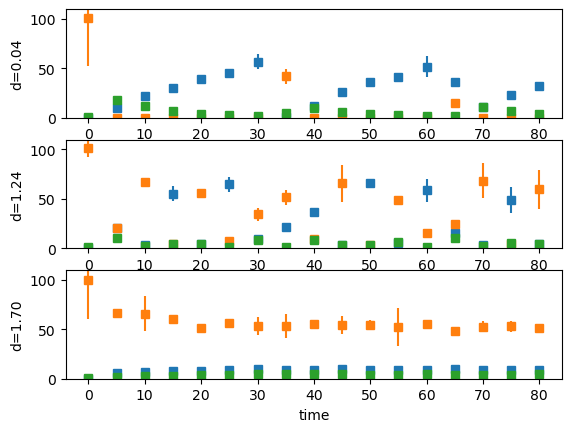

In [ ]:
# Plotting data with errorbars
fig,axs = plt.subplots(3,1)
axs[0].errorbar(data_time, mean_lowN, var_lowN, marker = 's', linestyle = '')
axs[0].errorbar(data_time, mean_lowC, var_lowC, marker = 's', linestyle = '')
axs[0].errorbar(data_time, mean_lowB, var_lowB, marker = 's', linestyle = '')
axs[0].set_xlabel('time')
axs[0].set_ylabel('d=0.04')
axs[0].set_ylim(bottom=0,top=110)

axs[1].errorbar(data_time, mean_midN, var_midN, marker = 's', linestyle = '')
axs[1].errorbar(data_time, mean_midC, var_midC, marker = 's', linestyle = '')
axs[1].errorbar(data_time, mean_midB, var_midB, marker = 's', linestyle = '')
axs[1].set_xlabel('time')
axs[1].set_ylabel('d=1.24')
axs[1].set_ylim(bottom=0,top=110)

axs[2].errorbar(data_time, mean_highN, var_highN, marker = 's', linestyle = '')
axs[2].errorbar(data_time, mean_highC, var_highC, marker = 's', linestyle = '')
axs[2].errorbar(data_time, mean_highB, var_highB, marker = 's', linestyle = '')
axs[2].set_xlabel('time')
axs[2].set_ylabel('d=1.70')
axs[2].set_ylim(bottom=0,top=110)

plt.show()

##### Conclusion
So what we observe here is that when $\delta = 0.04$ and $\delta = 1.24$ the concentrations of $N$, $C$, and $B$ show oscillations. As such, we would expect two of the three eigenvalues to be complex numbers with positive real values as the oscillations are unstable. When $\delta = 1.7$ we see that the concentrations are, roughly, at a steady state. So we would anticipate that the eigenvalues have all negative real values and, as there are no oscillations then there are no complex eigenvalues (but we cannot rule it out since the oscillations may dampen quickly).

#### b. perform a parameter scan and check eigenvalues

We have our function above to calculate the eigenvalues for a set of reaction rates. Here you will need to set up bounds and create a sample of 1000 parameter sets. Then you can iteratively test each parameter set, and check the eigenvalues for $\delta = 0.04$, $\delta = 1.24$, and $\delta = 1.70$. We then want to save the subset of the 1000 tested parameter sets that produce the eigenvalues we expect from the data above.

There are many, many ways to solve this problem. As a hint, in the solutions file I have provided a script that labels a parameter set with 1 for each predicted eigenvalue set that matches the data above (i.e. the first two sets of eigenvalues are not stable steady states, and the third set has all negative real values as required) and 0 otherwise. This allows me to then create a subsample of the 1000 parameter sets, containing those parameter sets with a "1" label.

As a guide, I found 181 parameter sets from my sample of 1000 that predicted the same eigenvalues as observed from the data.

It would be very useful to save your parameter samples (both the 1000 sets, and the subset with correct eigenvalues) using np.savetxt so that you do not need to recreate the samples on another day!

In [ ]:
# Order parameters: N(0), bb, bc, Kb, Kc, eps, m
lower_bounds = [-3,0.2,0.4,1.05,0.5,-1,-1.5]
upper_bounds = [-1,0.4,0.6,1.25,0.7,-0.5,-1]

# Create Latin Hypercube sample for d=7 dimensions
# Latin Hypercube samples create random sets of numbers between 0 and 1, so we need to stretch these bound using the for-loop below.
sampler = lhs.LatinHypercube(d=7)
sample = sampler.random(n=1000)

# Now, for each row/parameter in the sample matrix, we need to re-scale these using the bounds
for i in range(0, 7):
    sample[:,i] = lower_bounds[i] + (upper_bounds[i]-lower_bounds[i])*sample[:,i]
print(sample)

[[-1.28993656  0.23628074  0.46238997 ...  0.55207946 -0.77804943
  -1.38253293]
 [-1.51654413  0.2966188   0.58116448 ...  0.60010911 -0.95617917
  -1.15302197]
 [-2.85226208  0.20393217  0.57275571 ...  0.59350548 -0.95582912
  -1.13160067]
 ...
 [-1.96045084  0.35183897  0.59187979 ...  0.52733781 -0.79156961
  -1.09832381]
 [-1.03491227  0.38671148  0.45545151 ...  0.54527516 -0.96828144
  -1.0043844 ]
 [-1.34674435  0.39598899  0.56767808 ...  0.69275743 -0.65200749
  -1.29372679]]


In [ ]:
# Create zeros vectors/matrices to store eigenvalues and to label parameter sets with 1 if eigenvalues are correct
eigenvalues = np.zeros((3,3,len(sample[:,0])),dtype=np.complex_)
eigenvalue_parameters = np.zeros((len(sample[:,0]),1))

# Create for-loop to iteratively test each parameter set
for i in range(0,len(sample[:,0])):

    # Rescale parameters from logarithmic to linear scales
    n0,bb,bc,Kb,Kc,eps,m = np.power(10,sample[i,:])

    # Set timespan and initial conditions
    times = np.linspace(0,80,8001)
    initial_conditions = [n0,100,1]

    # Simulation 1
    Ni=80
    d=0.04
    # Simulate model
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss = calculate_steadyStates(xt)
    eig = calculate_eigenvalues(x_Ss, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[0,:,i] = eig

    # Simulation 2
    Ni=80
    d=1.24
    # Simulate model
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss = calculate_steadyStates(xt)
    eig = calculate_eigenvalues(x_Ss, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[1,:,i] = eig

    # Simulation 3
    Ni=80
    d=1.7
    # Simulate model
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss = calculate_steadyStates(xt)
    eig = calculate_eigenvalues(x_Ss, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[2,:,i] = eig

    # Given what we have seen above with our testing of these functions, we want the first two eigenvalue sets
    # to not represent stable steady states (including complex numbers) and the third eigenvalue set has three
    # negative real values. We will score a parameter set with a 1 if this is what we get.
    if ( (np.sum(np.where(abs(eigenvalues[0,:,i].imag)>0))>0) and (np.sum(np.where(abs(eigenvalues[1,:,i].imag)>0))>0) and (np.sum(np.where(abs(eigenvalues[2,:,i].imag)>0))==0) ):
        eigenvalue_parameters[i] = 1

# Reduce parameter sample to only those where the eigenvalues match data
eigenvalue_sample = sample[np.argwhere(eigenvalue_parameters==1)[:,0],:]

C:\Users\smith026\AppData\Local\Temp\ipykernel_14500\3852858988.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  num_x += X[0,j] / div
C:\Users\smith026\AppData\Local\Temp\ipykernel_14500\3852858988.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  num_y += X[1,j] / div
C:\Users\smith026\AppData\Local\Temp\ipykernel_14500\3852858988.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  num_z += X[2,j] / div


In [ ]:
# Save your parameter samples
np.savetxt('./param_sample_Python.csv',sample,delimiter=",",fmt="%.12f")
np.savetxt('./eigen_sample_Python.csv',eigenvalue_sample,delimiter=",",fmt="%.12f")

In [ ]:
# To see what solutions I got, you can load these files!
sample = np.loadtxt('./param_sample_Python.csv',delimiter=",")
eigenvalue_sample = np.loadtxt('./eigen_sample_Python.csv',delimiter=",")

#### c. fitting models to data

Above you have found parameter sets with eigenvalues that match the data. We now get to the time-consuming part of model building: using optimisation routines to find reaction rates such that time-series simulations match the data we have above.

To do this, we need an initial guess for parameter sets, bounds within which the search operates (that we will define as 10% higher or lower than the initial parameters) and a scoring function. This scoring function needs to take a set of reaction rates as the input, and output a score that tells us how well a simulation matches data.

Our scoring function will take the form given in the introduction lecture

\begin{align}
\Omega(\boldsymbol{p}) &= \sum_{i \in \delta=[0.04,1.24,1.7]} \sum_{j \in [N,C,B]} \omega_{i,j}(\boldsymbol{p}) \nonumber \\
\omega_{i,j}(\boldsymbol{p}) &= \sum_{t = t_1}^{t_f} \frac{\big(D_{i,j}(t)-M_{i,j}(t,\boldsymbol{p})\big)^2}{\sigma_{i,j}(t)^2}. \nonumber
\end{align}

In English, what this tells us is that we calculate the square difference between the data, $D$, and simulated time-series, $M$, for a concentration $j = [N, C, B]$ produced by parameter set $\boldsymbol{p}$. This is then divided by the variance of the data at the given timepoint, $\sigma^2$. This calculation is summed up for all timepoints from $t_1$ (ignore the zero timepoint as this has 0 variance in the data and leads to calculation issues) to the final measured timepoint $t_f$.

This difference then needs to be further summed for all concentrations measured and for different values of $\delta = [0.04, 1.24, 1.7]$ tested. As such, your code should contain multiple summation steps to calculate the final score $\Omega$ for a set of reaction rates $\boldsymbol{p}$.

This means that if $\Omega = 0$ then the model perfectly matches the data. $\Omega$, though, does not have a clearly defined upper bound so it is hard to judge what a "bad" score will be. I have made notes where needed as to scores you could expect.

As an initial guess for our search, take all parameter sets that had the correct eigenvalues and calculate the score obtained for these parameter sets (likely on the order of 10000s = $10^4$ or 100000s = $10^5$). If you do not get at least one parameter set on the order of $10^4$ then redo the sampling and eigenvalue calculation steps above.

Take the best scoring parameter set from these as our initial guess for further optimisation.

Along with an initial guess for a parameter set and the score function, optimisation algorithms also need bounds for the search space. We will take this to be 10% decreases and increases of the initial guess. These three objects are then inputs into the optimization algorithm we will use, and the algorithm will try to find a better solution/set of reaction rates within the search space such that simulations fit the data well.

The optimisation algorithm we are using, L-BFGS-B, is part of a family called "constrained minimization" algorithms.

To check whether your results are good or not, you are going to have to check the score, and simulate the model with the "optimal" parameter sets to plot simulations against your data! Note that my best parameter sets were getting scores around the 30000 mark... if you did not obtain a score around this value, then try a different initial starting parameter set for optimisation.

As with above: once you have a set of optimal parameter sets and scores, you will want to save these for future use!

#### Debug notes: errors or poor optimization routine

Due to the randomness of these algorithms (including the Latin hypercube sample above) your optimisation routine may give poor results where simulations do not fit the data well. If this is the case (your best parameter set has a score on the order of 1000000s = $10^6$ or 100000s = $10^5$ rather than 10000s = $10^4$ after optimisation) then this could be for a number of reasons. We will initially look at debugging this issue without utilising more data, i.e. we assume the problem is in the optimisation step and nothing to do with the experiments or model.

There are two solutions to this: either we have restricted our bounds too much at one stage of the model fitting, or we have not found a good initial guess before using the constrained minimiser.

When performing constrained minimisation above, we forced the bounds to be "local" around our initial guess (they are 10% increased or decreased from the initial guess). However, this may have been too restrictive, and we have missed out on finding a better combination of reaction rates that exist outside these bounds starting from our initial point. To solve this, we can set the bounds to our wider range used initially for Latin Hypercube sampling and re-run the optimisation routine.

To test this, we can simply repeat the optimisation step and the plot results against data. Take an initial guess that gave a poor result using the optimisation routine as an example, and re-run the optimisation algorithm with wider bounds.

Note that if you get any "Warnings" during the algorithm running, then do not worry about these. If you get "Errors" that stop the code from running then that needs fixing!

In [ ]:
# Define a scoring function with the input being a set of reaction rates
def score_function(ps):

    # Unpack parameters
    n0 = 10**ps[0]
    bb = 10**ps[1]
    bc = 10**ps[2]
    Kb = 10**ps[3]
    Kc = 10**ps[4]
    eps = 10**ps[5]
    m = 10**ps[6]

    # set timespan and initial conditions of the system
    times = np.linspace(0,80,8001)
    initial_conditions = [n0,100,1]
    Ni=80

    # simulate d=0.04
    d=0.04
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt1 = odeint(ncb_model, initial_conditions, times, pars)

    # for each concentration we now want to interpolate the simulation
    # we do this so that we only have simulated concentrations at
    # the same timepoints as where the data is measured
    # (an advantage to this approach is that calculating our score
    # then becomes a vector equation!)

    interp_Nlow = interp1d(times,xt1[:,0])
    sim_Nlow = interp_Nlow(data_time)

    interp_Clow = interp1d(times,xt1[:,1])
    sim_Clow = interp_Clow(data_time)

    interp_Blow = interp1d(times,xt1[:,2])
    sim_Blow = interp_Blow(data_time)

    # simulate d=1.24
    d=1.24
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt2 = odeint(ncb_model, initial_conditions, times, pars)

    # interpolate simulations
    interp_Nmid = interp1d(times,xt2[:,0])
    sim_Nmid = interp_Nmid(data_time)

    interp_Cmid = interp1d(times,xt2[:,1])
    sim_Cmid = interp_Cmid(data_time)

    interp_Bmid = interp1d(times,xt2[:,2])
    sim_Bmid = interp_Bmid(data_time)

    # simulte d=1.7
    d=1.7
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt3 = odeint(ncb_model, initial_conditions, times, pars)

    # interpolate simulations
    interp_Nhigh = interp1d(times,xt3[:,0])
    sim_Nhigh = interp_Nhigh(data_time)

    interp_Chigh = interp1d(times,xt3[:,1])
    sim_Chigh = interp_Chigh(data_time)

    interp_Bhigh = interp1d(times,xt3[:,2])
    sim_Bhigh = interp_Bhigh(data_time)

    # Calculate score
    omega_low = np.sum((mean_lowN[1:]-sim_Nlow[1:])**2/var_lowN[1:]) + np.sum((mean_lowC[1:]-sim_Clow[1:])**2/var_lowC[1:]) + np.sum((mean_lowB[1:]-sim_Blow[1:])**2/var_lowB[1:])
    omega_mid = np.sum((mean_midN[1:]-sim_Nmid[1:])**2/var_midN[1:]) + np.sum((mean_midC[1:]-sim_Cmid[1:])**2/var_midC[1:]) + np.sum((mean_midB[1:]-sim_Bmid[1:])**2/var_midB[1:])
    omega_high = np.sum((mean_highN[1:]-sim_Nhigh[1:])**2/var_highN[1:]) + np.sum((mean_highC[1:]-sim_Chigh[1:])**2/var_highC[1:]) + np.sum((mean_highB[1:]-sim_Bhigh[1:])**2/var_highB[1:])

    # Sum up subscores to one value
    score = omega_low + omega_mid + omega_high

    return score

In [ ]:
# Create zeros vectors/matrices to store scores
eigenvalue_scores = np.zeros((len(eigenvalue_sample[:,0]),2))

# Create for-loop to iteratively test each parameter set
for i in range(0,len(eigenvalue_sample[:,0])):
    s = score_function(eigenvalue_sample[i,:])
    eigenvalue_scores[i,:] = [i,s]

eigenvalue_scores = eigenvalue_scores[eigenvalue_scores[:,1].argsort()]
print(eigenvalue_scores)

[[1.73000000e+02 2.99295979e+04]
 [1.20000000e+02 2.27861218e+05]
 [1.26000000e+02 3.31489386e+05]
 [3.50000000e+01 3.89904848e+05]
 [1.80000000e+01 4.01839682e+05]
 [1.10000000e+01 4.11507388e+05]
 [1.25000000e+02 4.27925144e+05]
 [1.10000000e+02 4.44125390e+05]
 [2.00000000e+01 4.56936697e+05]
 [1.78000000e+02 4.93487189e+05]
 [6.40000000e+01 5.03168807e+05]
 [1.37000000e+02 5.05363454e+05]
 [7.10000000e+01 5.10533348e+05]
 [1.70000000e+01 5.18672036e+05]
 [3.60000000e+01 5.63220263e+05]
 [4.50000000e+01 5.96522071e+05]
 [1.36000000e+02 6.03099761e+05]
 [1.60000000e+01 6.47511459e+05]
 [6.70000000e+01 6.70979251e+05]
 [1.71000000e+02 6.83991761e+05]
 [3.40000000e+01 7.23680066e+05]
 [3.30000000e+01 7.55264450e+05]
 [1.29000000e+02 7.58144328e+05]
 [7.20000000e+01 7.72806656e+05]
 [6.80000000e+01 7.81449387e+05]
 [1.31000000e+02 8.04437562e+05]
 [1.35000000e+02 8.64390257e+05]
 [7.00000000e+01 8.84092345e+05]
 [1.44000000e+02 9.45676203e+05]
 [9.00000000e+01 9.53817393e+05]
 [9.900000

In [ ]:
# Test optimisation starting from a parameter set with correct predicted eigenvalues

# To illustrate how to use an optimisation routine, I will provide an example script here: you need to define an initial
# parameter set from which the search for a parameter set begins, you need to define bounds for the search space, and then
# perform the optimisation and collect results

# Set initial parameter set guess
j = int(eigenvalue_scores[0,0])
init_p = eigenvalue_sample[j,:]

# Set bounds to be 10% increase and decrease of initial point
bounds = opt.Bounds(init_p-0.1,init_p+0.1)

# Perform minimization/optimization routine that uses our score function to calculate how well a parameter set matches data.
# This starts from the initial guess, and uses the L-BFGS-B method to work out how to change parameter sets to find better
# solutions within our bounds. The display options allow you to observe how the result is improving over each iteration.
opt_out = opt.minimize(score_function,init_p,method='L-BFGS-B',bounds=bounds,options={'disp':True,'maxiter':1000})

# Obtain the best found set of parameters and it's corresponding score
opt_scores = opt_out.fun
opt_params = opt_out.x

print(opt_scores)
print(opt_params)

29929.597896769137
[-2.14264313  0.34927376  0.51684839  1.18461394  0.68589881 -0.63723316
 -1.30828604]


In [ ]:
np.savetxt('./opt_params_scores_Python.csv',np.append(opt_params,opt_scores),delimiter=",")

In [ ]:
# Loading my previous results
opt_param_score = np.loadtxt('./opt_params_scores_Python.csv',delimiter=",")
opt_params = opt_param_score[0:-1]
opt_scores = opt_param_score[-1]

In [ ]:
# We also need a script to plot simulations against data to check our results.
# We can also calculate the score here and obtain eigenvalues, so this script is essentially the same as the
# score function above but with some extra things added!

def data_plot_function(ps):

    # Unpack parameters
    n0 = 10**ps[0]
    bb = 10**ps[1]
    bc = 10**ps[2]
    Kb = 10**ps[3]
    Kc = 10**ps[4]
    eps = 10**ps[5]
    m = 10**ps[6]

    # Collect eigenvalues
    eigs = np.zeros((3,3),dtype = np.complex_)

    # set timespan and initial conditions of the system
    times = np.linspace(0,80,8001)
    initial_conditions = [n0,100,1]
    Ni=80

    # simulate d=0.04 and calculate eigenvalues
    d=0.04
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt1 = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss1 = calculate_steadyStates(xt1)
    eig = calculate_eigenvalues(x_Ss1, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigs[0,:] = eig

    # for each concentration we now want to interpolate the simulation
    # we do this so that we only have simulated concentrations at
    # the same timepoints as where the data is measured
    # (an advantage to this approach is that calculating our score
    # then becomes a vector equation!)

    interp_Nlow = interp1d(times,xt1[:,0])
    sim_Nlow = interp_Nlow(data_time)

    interp_Clow = interp1d(times,xt1[:,1])
    sim_Clow = interp_Clow(data_time)

    interp_Blow = interp1d(times,xt1[:,2])
    sim_Blow = interp_Blow(data_time)

    # simulate d=1.24 and calculate eigenvalues
    d=1.24
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt2 = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss2 = calculate_steadyStates(xt2)
    eig = calculate_eigenvalues(x_Ss2, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigs[1,:] = eig

    # interpolate simulations
    interp_Nmid = interp1d(times,xt2[:,0])
    sim_Nmid = interp_Nmid(data_time)

    interp_Cmid = interp1d(times,xt2[:,1])
    sim_Cmid = interp_Cmid(data_time)

    interp_Bmid = interp1d(times,xt2[:,2])
    sim_Bmid = interp_Bmid(data_time)

    # simulte d=1.7 and calculate eigenvalues
    d=1.7
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt3 = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss3 = calculate_steadyStates(xt3)
    eig = calculate_eigenvalues(x_Ss3, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigs[2,:] = eig

    # interpolate simulations
    interp_Nhigh = interp1d(times,xt3[:,0])
    sim_Nhigh = interp_Nhigh(data_time)

    interp_Chigh = interp1d(times,xt3[:,1])
    sim_Chigh = interp_Chigh(data_time)

    interp_Bhigh = interp1d(times,xt3[:,2])
    sim_Bhigh = interp_Bhigh(data_time)

    # Calculate score
    omega_low = np.sum((mean_lowN[1:]-sim_Nlow[1:])**2/var_lowN[1:]) + np.sum((mean_lowC[1:]-sim_Clow[1:])**2/var_lowC[1:]) + np.sum((mean_lowB[1:]-sim_Blow[1:])**2/var_lowB[1:])
    omega_mid = np.sum((mean_midN[1:]-sim_Nmid[1:])**2/var_midN[1:]) + np.sum((mean_midC[1:]-sim_Cmid[1:])**2/var_midC[1:]) + np.sum((mean_midB[1:]-sim_Bmid[1:])**2/var_midB[1:])
    omega_high = np.sum((mean_highN[1:]-sim_Nhigh[1:])**2/var_highN[1:]) + np.sum((mean_highC[1:]-sim_Chigh[1:])**2/var_highC[1:]) + np.sum((mean_highB[1:]-sim_Bhigh[1:])**2/var_highB[1:])

    # Sum up subscores to one value
    score = omega_low + omega_mid + omega_high

    # Plot simulations against data: to do this you may want to use subplots and errorbars
    fig,axs = plt.subplots(3,1)
    axs[0].errorbar(data_time, mean_lowN, var_lowN, marker = 's', linestyle = '')
    axs[0].errorbar(data_time, mean_lowC, var_lowC, marker = 's', linestyle = '')
    axs[0].errorbar(data_time, mean_lowB, var_lowB, marker = 's', linestyle = '')
    axs[0].plot(times,xt1)
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('d=0.04')
    axs[0].set_ylim(bottom=0,top=110)

    axs[1].errorbar(data_time, mean_midN, var_midN, marker = 's', linestyle = '')
    axs[1].errorbar(data_time, mean_midC, var_midC, marker = 's', linestyle = '')
    axs[1].errorbar(data_time, mean_midB, var_midB, marker = 's', linestyle = '')
    axs[1].plot(times,xt2)
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('d=1.24')
    axs[1].set_ylim(bottom=0,top=110)

    axs[2].errorbar(data_time, mean_highN, var_highN, marker = 's', linestyle = '')
    axs[2].errorbar(data_time, mean_highC, var_highC, marker = 's', linestyle = '')
    axs[2].errorbar(data_time, mean_highB, var_highB, marker = 's', linestyle = '')
    axs[2].plot(times,xt3)
    axs[2].set_xlabel('time')
    axs[2].set_ylabel('d=1.70')
    axs[2].set_ylim(bottom=0,top=110)

    plt.show()

    return score, eigs


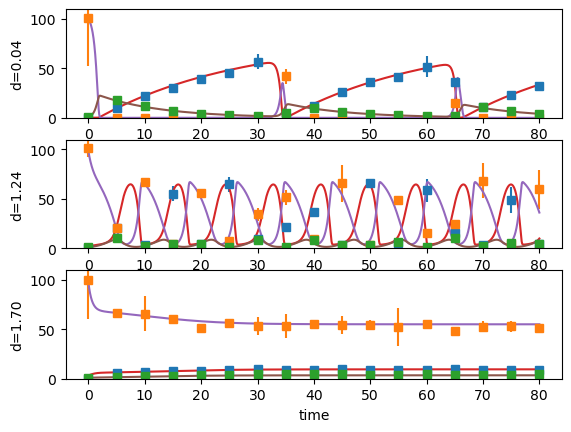

29929.597896769137
[[-0.06033114+0.j          0.21914618+1.87261007j  0.21914618-1.87261007j]
 [-1.26033114+0.j         -0.98085382+1.87261007j -0.98085382-1.87261007j]
 [-1.71193435+0.j         -0.6228366 +0.79508443j -0.6228366 -0.79508443j]]


In [ ]:
# Use data plot function to obtain figures, score, and eigenvalues
score, eigs = data_plot_function(opt_params)
print(score)
print(eigs)

##### Conclusion

Through the data fitting stage we can see that, even with a score of around 30000, the simulations qualitatively match the data pretty well. When we want oscillations, we obtain oscillations, and when we want steady states, we see steady states. The eigenvalues that we have estimated do not match with the dynamics we observe perfectly. In the final eigenvalue set I have obtained complex numbers: however the negative real part is indicative of dampening oscillations towards a steady state so I am willing to overlook this here given the fit to data.

## Writing exercise

Write a figure caption for the plots you obtain comparing optimal simulations with data. Then, write a short paragraph analysing the result you have obtained. Ask your neighbour if what you have written is clear and follows the rules discussed in our previous writing exercise.

### Solution

Figure caption: Comparisons of optimal simulations with data. The experimental conditions evaluated include (Top) $d = 0.04$, (Middle) $d = 1.24$, and (Bottom) $d = 1.7$. In each panel simulations of $N$ (red line), $C$ (purple line), and $B$ (brown line) are compared with data for $N$ (blue squares), $C$ (orange squares), and $B$ (green squares). Error bars represent variance from three experimental replicates.

Results paragraph: The data showed that our bioreactor had oscillations when $d = 0.04$ and $d = 1.24$ but a stable steady state was observed fror $d = 1.7$. Using this observation, we searched for reaction rates in our model that yielded unstable and stable eigenvalues (for the different conditions, respectively) and then fine-tuned our model through data-fitting. The resulting optimal simulations can be observed in Figure X, and yielded a score of 30000 from our scoring function. We observe here that, broadly speaking, our optimal model is able to match the data well: showing oscillations as required when $d$ is low and a system that reaches a stable steady state when $d = 1.7$. On top of this, the simulations go through the majority of the errorbars of the data suggesting that our optimal model is representative of the experimental system. Consequently, using this optimal model, we can now look to predict follow up experiments where both $d$ and $N_i$ are varied.

## Part 7: validate model against new "unseen" data

The true test of a model is to judge whether simulations can match data obtained from experimental conditions that are not used for model fitting. So far we have considered what happens when $\delta$ is fixed throughout an experiment with $N_i = 80$, however we also have data for when $N_i = 514$.

You will need to first load the data (again available on Brightspace but this the three replicates filenames contain n514 (and not n80) and organise this. Then you will need to write a script to perform the simulation outlined above. Simulate the model with your optimal parameter set and, with plots, see if the simulation matches the data. The same $\delta$ values can be used as before, as well as initial conditions, and time-length.

You will eventually create a score function for this new data, so you can test that within this plotting function already. Also check whether the predicted eigenvalues you obtain match what you expect from data.

#### Debug note

You may find that your simulations when $N_i = 514$ do not match the data very well at all. This would suggest that we are either using an incorrect parameter set, or the model is wrong somewhere. For now, we are going to assume that the model is correct, but that the parameter set we are using is incorrect. We will, in the next part, then refit the model including these new datasets.

In [ ]:
# Load data for d = 0.04 (low) and organise data
data_timeV, data_lowN1v, data_lowC1v, data_lowB1v = np.loadtxt("./d004n514_rep1.csv",delimiter=",",unpack=True)
data_timeV, data_lowN2v, data_lowC2v, data_lowB2v = np.loadtxt("./d004n514_rep2.csv",delimiter=",",unpack=True)
data_timeV, data_lowN3v, data_lowC3v, data_lowB3v = np.loadtxt("./d004n514_rep3.csv",delimiter=",",unpack=True)
mean_lowNv = np.mean([data_lowN1v, data_lowN2v, data_lowN3v],axis=0)
mean_lowCv = np.mean([data_lowC1v, data_lowC2v, data_lowC3v],axis=0)
mean_lowBv = np.mean([data_lowB1v, data_lowB2v, data_lowB3v],axis=0)
var_lowNv = np.var([data_lowN1v, data_lowN2v, data_lowN3v],axis=0)
var_lowCv = np.var([data_lowC1v, data_lowC2v, data_lowC3v],axis=0)
var_lowBv = np.var([data_lowB1v, data_lowB2v, data_lowB3v],axis=0)

# Load data for d = 1.24 (mid)
data_timeV, data_midN1v, data_midC1v, data_midB1v = np.loadtxt("./d124n514_rep1.csv",delimiter=",",unpack=True)
data_timeV, data_midN2v, data_midC2v, data_midB2v = np.loadtxt("./d124n514_rep2.csv",delimiter=",",unpack=True)
data_timeV, data_midN3v, data_midC3v, data_midB3v = np.loadtxt("./d124n514_rep3.csv",delimiter=",",unpack=True)
mean_midNv = np.mean([data_midN1v, data_midN2v, data_midN3v],axis=0)
mean_midCv = np.mean([data_midC1v, data_midC2v, data_midC3v],axis=0)
mean_midBv = np.mean([data_midB1v, data_midB2v, data_midB3v],axis=0)
var_midNv = np.var([data_midN1v, data_midN2v, data_midN3v],axis=0)
var_midCv = np.var([data_midC1v, data_midC2v, data_midC3v],axis=0)
var_midBv = np.var([data_midB1v, data_midB2v, data_midB3v],axis=0)

# Load data for d = 1.7 (high)
data_timeV, data_highN1v, data_highC1v, data_highB1v = np.loadtxt("./d170n514_rep1.csv",delimiter=",",unpack=True)
data_timeV, data_highN2v, data_highC2v, data_highB2v = np.loadtxt("./d170n514_rep2.csv",delimiter=",",unpack=True)
data_timeV, data_highN3v, data_highC3v, data_highB3v = np.loadtxt("./d170n514_rep3.csv",delimiter=",",unpack=True)
mean_highNv = np.mean([data_highN1v, data_highN2v, data_highN3v],axis=0)
mean_highCv = np.mean([data_highC1v, data_highC2v, data_highC3v],axis=0)
mean_highBv = np.mean([data_highB1v, data_highB2v, data_highB3v],axis=0)
var_highNv = np.var([data_highN1v, data_highN2v, data_highN3v],axis=0)
var_highCv = np.var([data_highC1v, data_highC2v, data_highC3v],axis=0)
var_highBv = np.var([data_highB1v, data_highB2v, data_highB3v],axis=0)

In [ ]:
def newData_plot_function(ps):

    # Unpack parameters
    n0 = 10**ps[0]
    bb = 10**ps[1]
    bc = 10**ps[2]
    Kb = 10**ps[3]
    Kc = 10**ps[4]
    eps = 10**ps[5]
    m = 10**ps[6]

    # set timespan and initial conditions of the system
    # Set timespan + initial conditions
    times = np.linspace(0,80,8001)
    initial_conditions = [n0,100,1]
    eigenvalues = np.zeros((6,3),dtype=np.complex_)

    # low N
    Ni=80

    # low d
    d=0.04
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt1 = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss1 = calculate_steadyStates(xt1)
    eig = calculate_eigenvalues(x_Ss1, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[0,:] = eig

    interp_Nlow = interp1d(times,xt1[:,0])
    sim_Nlow = interp_Nlow(data_time)

    interp_Clow = interp1d(times,xt1[:,1])
    sim_Clow = interp_Clow(data_time)

    interp_Blow = interp1d(times,xt1[:,2])
    sim_Blow = interp_Blow(data_time)

    # mid d
    d=1.24
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt2 = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss2 = calculate_steadyStates(xt2)
    eig = calculate_eigenvalues(x_Ss2, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[1,:] = eig

    interp_Nmid = interp1d(times,xt2[:,0])
    sim_Nmid = interp_Nmid(data_time)

    interp_Cmid = interp1d(times,xt2[:,1])
    sim_Cmid = interp_Cmid(data_time)

    interp_Bmid = interp1d(times,xt2[:,2])
    sim_Bmid = interp_Bmid(data_time)

    # high d
    d=1.7
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt3 = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss3 = calculate_steadyStates(xt3)
    eig = calculate_eigenvalues(x_Ss3, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[2,:] = eig

    interp_Nhigh = interp1d(times,xt3[:,0])
    sim_Nhigh = interp_Nhigh(data_time)

    interp_Chigh = interp1d(times,xt3[:,1])
    sim_Chigh = interp_Chigh(data_time)

    interp_Bhigh = interp1d(times,xt3[:,2])
    sim_Bhigh = interp_Bhigh(data_time)

    # high N
    Ni=514

    # low d
    d=0.04
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt1v = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss1v = calculate_steadyStates(xt1v)
    eig = calculate_eigenvalues(x_Ss1v, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[3,:] = eig

    interp_Nlow = interp1d(times,xt1v[:,0])
    sim_NlowV = interp_Nlow(data_timeV)

    interp_Clow = interp1d(times,xt1v[:,1])
    sim_ClowV = interp_Clow(data_timeV)

    interp_Blow = interp1d(times,xt1v[:,2])
    sim_BlowV = interp_Blow(data_timeV)

    # mid d
    d=1.24
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt2v = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss2v = calculate_steadyStates(xt2v)
    eig = calculate_eigenvalues(x_Ss2v, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[4,:] = eig

    interp_Nmid = interp1d(times,xt2v[:,0])
    sim_NmidV = interp_Nmid(data_timeV)

    interp_Cmid = interp1d(times,xt2v[:,1])
    sim_CmidV = interp_Cmid(data_timeV)

    interp_Bmid = interp1d(times,xt2v[:,2])
    sim_BmidV = interp_Bmid(data_timeV)

    # high d
    d=1.7
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt3v = odeint(ncb_model, initial_conditions, times, pars)
    x_Ss3v = calculate_steadyStates(xt3v)
    eig = calculate_eigenvalues(x_Ss3v, Ni, d, bb, bc, Kb, Kc, eps, m)
    eigenvalues[5,:] = eig

    interp_Nhigh = interp1d(times,xt3v[:,0])
    sim_NhighV = interp_Nhigh(data_timeV)

    interp_Chigh = interp1d(times,xt3v[:,1])
    sim_ChighV = interp_Chigh(data_timeV)

    interp_Bhigh = interp1d(times,xt3v[:,2])
    sim_BhighV = interp_Bhigh(data_timeV)

    # Calculate score
    omega_low = np.sum((mean_lowN[1:len(sim_Nlow[1:])+1]-sim_Nlow[1:])**2/var_lowN[1:len(sim_Nlow[1:])+1]) + np.sum((mean_lowC[1:len(sim_Clow[1:])+1]-sim_Clow[1:])**2/var_lowC[1:len(sim_Nlow[1:])+1]) + np.sum((mean_lowB[1:len(sim_Blow[1:])+1]-sim_Blow[1:])**2/var_lowB[1:len(sim_Blow[1:])+1])
    omega_mid = np.sum((mean_midN[1:len(sim_Nmid[1:])+1]-sim_Nmid[1:])**2/var_midN[1:len(sim_Nmid[1:])+1]) + np.sum((mean_midC[1:len(sim_Cmid[1:])+1]-sim_Cmid[1:])**2/var_midC[1:len(sim_Clow[1:])+1]) + np.sum((mean_midB[1:len(sim_Bmid[1:])+1]-sim_Bmid[1:])**2/var_midB[1:len(sim_Bmid[1:])+1])
    omega_high = np.sum((mean_highN[1:len(sim_Nhigh[1:])+1]-sim_Nhigh[1:])**2/var_highN[1:len(sim_Nhigh[1:])+1]) + np.sum((mean_highC[1:len(sim_Chigh[1:])+1]-sim_Chigh[1:])**2/var_highC[1:len(sim_Chigh[1:])+1]) + np.sum((mean_highB[1:len(sim_Bhigh[1:])+1]-sim_Bhigh[1:])**2/var_highB[1:len(sim_Bhigh[1:])+1])
    omega_lowV = np.sum((mean_lowNv[1:len(sim_NlowV[1:])+1]-sim_NlowV[1:])**2/var_lowNv[1:len(sim_NlowV[1:])+1]) + np.sum((mean_lowCv[1:len(sim_ClowV[1:])+1]-sim_ClowV[1:])**2/var_lowCv[1:len(sim_ClowV[1:])+1]) + np.sum((mean_lowBv[1:len(sim_BlowV[1:])+1]-sim_BlowV[1:])**2/var_lowBv[1:len(sim_BlowV[1:])+1])
    omega_midV = np.sum((mean_midNv[1:len(sim_NmidV[1:])+1]-sim_NmidV[1:])**2/var_midNv[1:len(sim_NmidV[1:])+1]) + np.sum((mean_midCv[1:len(sim_CmidV[1:])+1]-sim_CmidV[1:])**2/var_midCv[1:len(sim_CmidV[1:])+1]) + np.sum((mean_midBv[1:len(sim_BmidV[1:])+1]-sim_BmidV[1:])**2/var_midBv[1:len(sim_BmidV[1:])+1])
    omega_highV = np.sum((mean_highNv[1:len(sim_NhighV[1:])+1]-sim_NhighV[1:])**2/var_highNv[1:len(sim_NhighV[1:])+1]) + np.sum((mean_highCv[1:len(sim_ChighV[1:])+1]-sim_ChighV[1:])**2/var_highCv[1:len(sim_ChighV[1:])+1]) + np.sum((mean_highBv[1:len(sim_BhighV[1:])+1]-sim_BhighV[1:])**2/var_highBv[1:len(sim_BhighV[1:])+1])

    # Sum up subscores to one value
    score = omega_low + omega_mid + omega_high + omega_lowV + omega_midV + omega_highV

    # Plot simulations against data
    fig,axs = plt.subplots(3,2)
    axs[0,0].errorbar(data_time, mean_lowN, var_lowN, marker = 's', linestyle = '')
    axs[0,0].errorbar(data_time, mean_lowC, var_lowC, marker = 's', linestyle = '')
    axs[0,0].errorbar(data_time, mean_lowB, var_lowB, marker = 's', linestyle = '')
    axs[0,0].plot(times,xt1)
    axs[0,0].set_xlabel('time')
    axs[0,0].set_ylabel('d=0.04')
    axs[0,0].set_ylim(bottom=0,top=110)

    axs[1,0].errorbar(data_time, mean_midN, var_midN, marker = 's', linestyle = '')
    axs[1,0].errorbar(data_time, mean_midC, var_midC, marker = 's', linestyle = '')
    axs[1,0].errorbar(data_time, mean_midB, var_midB, marker = 's', linestyle = '')
    axs[1,0].plot(times,xt2)
    axs[1,0].set_xlabel('time')
    axs[1,0].set_ylabel('d=1.24')
    axs[1,0].set_ylim(bottom=0,top=110)

    axs[2,0].errorbar(data_time, mean_highN, var_highN, marker = 's', linestyle = '')
    axs[2,0].errorbar(data_time, mean_highC, var_highC, marker = 's', linestyle = '')
    axs[2,0].errorbar(data_time, mean_highB, var_highB, marker = 's', linestyle = '')
    axs[2,0].plot(times,xt3)
    axs[2,0].set_xlabel('time')
    axs[2,0].set_ylabel('d=1.70')
    axs[2,0].set_ylim(bottom=0,top=110)

    axs[0,1].errorbar(data_timeV, mean_lowNv, var_lowNv, marker = 's', linestyle = '')
    axs[0,1].errorbar(data_timeV, mean_lowCv, var_lowCv, marker = 's', linestyle = '')
    axs[0,1].errorbar(data_timeV, mean_lowBv, var_lowBv, marker = 's', linestyle = '')
    axs[0,1].plot(times,xt1v)
    axs[0,1].set_xlabel('time')
    axs[0,1].set_ylabel('d=0.04')
    axs[0,1].set_ylim(bottom=0,top=600)

    axs[1,1].errorbar(data_timeV, mean_midNv, var_midNv, marker = 's', linestyle = '')
    axs[1,1].errorbar(data_timeV, mean_midCv, var_midCv, marker = 's', linestyle = '')
    axs[1,1].errorbar(data_timeV, mean_midBv, var_midBv, marker = 's', linestyle = '')
    axs[1,1].plot(times,xt2v)
    axs[1,1].set_xlabel('time')
    axs[1,1].set_ylabel('d=1.24')
    axs[1,1].set_ylim(bottom=0,top=600)

    axs[2,1].errorbar(data_timeV, mean_highNv, var_highNv, marker = 's', linestyle = '')
    axs[2,1].errorbar(data_timeV, mean_highCv, var_highCv, marker = 's', linestyle = '')
    axs[2,1].errorbar(data_timeV, mean_highBv, var_highBv, marker = 's', linestyle = '')
    axs[2,1].plot(times,xt3v)
    axs[2,1].set_xlabel('time')
    axs[2,1].set_ylabel('d=1.70')
    axs[2,1].set_ylim(bottom=0,top=600)

    plt.show()

    return score, eigenvalues

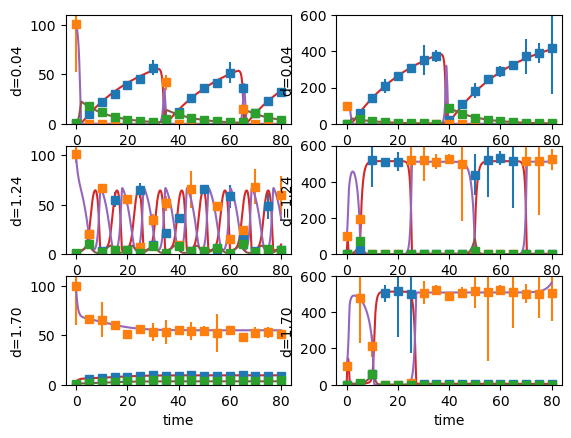

26280363.421686545
[[-0.06033114+0.j          0.21914618+1.87261007j  0.21914618-1.87261007j]
 [-1.26033114+0.j         -0.98085382+1.87261007j -0.98085382-1.87261007j]
 [-1.71193435+0.j         -0.6228366 +0.79508443j -0.6228366 -0.79508443j]
 [-0.05193435+0.j          1.0371634 +0.79508443j  1.0371634 -0.79508443j]
 [-1.25193435+0.j         -0.1628366 +0.79508443j -0.1628366 -0.79508443j]
 [-1.71193435+0.j         -0.6228366 +0.79508443j -0.6228366 -0.79508443j]]


In [ ]:
score, eigs = newData_plot_function(opt_params)
print(score)
print(eigs)

##### Conclusion

As before, the simulations look like a good match to the data! The estimated eigenvalues do not appear to match the dynamics we observe, but I would conclude that we have a decent model here!

## Part 8: making a hypothesis

Above, you should have been able to obtain a parameter set such that model simulations match data when $N_i = 80$ and possibly also for $N_i = 514$ (although this is a tougher task so it's ok if the matches are not perfect!) and $\delta$ is varied. However, in all these experiments, we have assumed that the experimental conditions do not change with time...

If we assume that our model is now sufficiently "good" (and it is not easy to judge when this was the case - a good rule of thumb is that the simulations go through the errorbars of the data) then we can compare our model with previously "unseen" data and then make hypotheses. Your tasks are as follows:

We have data obtained from conditions where $N_i = 80$ and $\delta$ switches from 1.7 at $t = 30$ to 0.95 until $t = 80$, at which time the experiment stops. You can obtain the data from Brightspace named "validation...". The initial conditions for the experiment $(C,B) = (50,1)$. You need to load this data, simulate the model for these conditions using our optimal parameter sets, and then plot the simulations with the data to check the match. You may find that one optimal parameter set performs better than another one that you have found...

Discuss what you hypothesise from your simulations, and what you would expect to see experimentally. Find somebody who coded the problem in R and compare your predictions from this simulation.

### Solution

#### Match unseen data

To solve this problem, you need to load and organise the data. Then you need to create a script to simulate the experiments and plot the simulations against data. We will test this using the optimal parameter sets that you have found.

In [ ]:
# Load validation data and organise means/variances
data_time_val, data_valN1, data_valC1, data_valB1 = np.loadtxt("./validation_rep1.csv",delimiter=",",unpack=True)
data_time_val, data_valN2, data_valC2, data_valB2 = np.loadtxt("./validation_rep2.csv",delimiter=",",unpack=True)
data_time_val, data_valN3, data_valC3, data_valB3 = np.loadtxt("./validation_rep3.csv",delimiter=",",unpack=True)
mean_valN = np.mean([data_valN1, data_valN2, data_valN3],axis=0)
mean_valC = np.mean([data_valC1, data_valC2, data_valC3],axis=0)
mean_valB = np.mean([data_valB1, data_valB2, data_valB3],axis=0)
var_valN = np.var([data_valN1, data_valN2, data_valN3],axis=0)
var_valC = np.var([data_valC1, data_valC2, data_valC3],axis=0)
var_valB = np.var([data_valB1, data_valB2, data_valB3],axis=0)

In [ ]:
# Create a plotting script to simulate the new experiment for a given parameter set and plot simulations against data
def plot_validation(ps):

    # Unpack parameters
    n0 = 10**ps[0]
    bb = 10**ps[1]
    bc = 10**ps[2]
    Kb = 10**ps[3]
    Kc = 10**ps[4]
    eps = 10**ps[5]
    m = 10**ps[6]

    # Simulate first condition until t = 30
    times1 = np.linspace(0,30,3001)
    initial_conditions1 = [n0,50,1]
    Ni=80
    d=1.7
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt1 = odeint(ncb_model, initial_conditions1, times1, pars)

    # Simulate second condition from t = 30 to t = 80, using the final concentrations
    # of the first simulation as the initial concentrations of the second
    times2 = np.linspace(n0,50,5001)
    initial_conditions2 = xt1[-1,:]
    d=0.95
    pars = (Ni, d, bb, bc, Kb, Kc, eps, m)
    xt2 = odeint(ncb_model, initial_conditions2, times2, pars)

    # Combine simulated results together
    times = np.r_[times1,times2[1:]+times1[-1]]
    xtV = np.r_[xt1,xt2[1:,:]]

    # Plot simulations against data
    fig,axs = plt.subplots(1,1)
    axs.errorbar(data_time_val, mean_valN, var_valN, marker = 's', linestyle = '')
    axs.errorbar(data_time_val, mean_valC, var_valC, marker = 's', linestyle = '')
    axs.errorbar(data_time_val, mean_valB, var_valB, marker = 's', linestyle = '')
    axs.plot(times,xtV)
    axs.set_xlabel('time')
    axs.set_ylim(bottom=0,top=110)

    plt.show()

    return

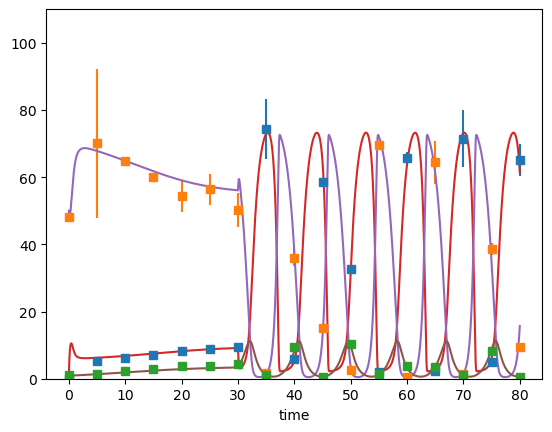

In [ ]:
# Plot simulations against data for optimal parameter set
plot_validation(opt_params)

##### Conclusion:
The fit here looks pretty good! The results show steady states initially and then generating oscillations when $\delta$ changes.

## Last writing exercise

Write a figure caption and write a paragraph that analyses the figure you obtained above!

### Solution

Figure caption: Model describes experimental conditions in the low $N_i$ range when $\delta$ is varied. At $t = 30$, $\delta$ is decreased from 1.7 to 0.95 until the end of the experiment. Data is represented as squares ($N$: blue, $C$: orange, $B$: green) and simulations as solid lines ($N$: red, $C$: purple, $B$: brown). Error bars represent variance of three experimental replicates.

Results text: Based on our model fits and comparison with data at $N = 80$ and $N = 514$, we concluded that our model was able to accurately describe experiments in the low-$N$ range for varying $\delta$. To confirm that this is the case, we simulated a novel experimental set-up where $\delta$ is decreased from 1.7 to 0.95 at $t = 30$. Our simulations (Figure X) showed that the system, in these conditions, should cross a Hopf bifurcation such that oscillations are observed as $\delta$ is decreased. This behaviour was confirmed in experimental data obtained from these conditions. Based on these results, we have faith that our model accurately reflects our reactor system when $N = 80$.

## Final conclusion

The goal of this week's exercise was to show you how to build models given biological information, and how to combine model analysis with data fitting. This allows you to draw conclusions and make hypotheses about the biological system of interest. Whilst we have presented one way in which these methods can be combined, you will find many different combinations presented in published research.

In this practical, you have:

1. used your modelling skills to derive equations from a picture and written information

2. performed model analysis to determine the stability of your model for any given set of reaction rates

3. used your eigenvalue analysis to find parameter sets that could match provided data

4. finetuned your parameter guesses by using optimisation routines and directly fitting model simulations with data

5. analysed the results of model optimisation and made further hypotheses in an iterative cycle

The steps outlined here are, essentially, the same for all modelling tasks that a researcher faces.

You may, though, have also encountered many difficulties that modellers face: particularly related to model solvers, model sensitivity and identifiability. We have tried to highlight these issues and how modellers consider solutions to these problems.

Take time to reflect on what went well and what was tough during this week. It will likely be useful to find a project partner for next week with complimentary skills to you so you form a complete team together.

We hope you have enjoyed practicing these skills and now know how to go about complete a modelling project independently next week!